In [117]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.base import clone
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
)

plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

# Разведочный анализ данных

In [95]:
train_df = pd.read_csv('train_c.csv')
test_df = pd.read_csv('test_c.csv')
print(f"Размер обучающей выборки: {train_df.shape}")
print(f"Размер тестовой выборки: {test_df.shape}")

Размер обучающей выборки: (11017, 35)
Размер тестовой выборки: (5000, 35)


In [96]:
def basic_info(df):
    """Базовая информация о датасете"""
    print("\n" + "=" * 80)
    print("БАЗОВАЯ ИНФОРМАЦИЯ О ДАННЫХ")
    print("=" * 80)

    print("\nПервые 5 строк:")
    print(df.head())

    print("\nИнформация о типах данных:")
    print(df.info())

    print("\nСтатистическое описание:")
    print(df.describe())

    print("\nПропущенные значения:")
    missing = df.isnull().sum()
    missing_percent = 100 * missing / len(df)
    missing_table = pd.DataFrame({"Пропущено": missing, "Процент": missing_percent})
    print(missing_table[missing_table["Пропущено"] > 0].sort_values("Пропущено", ascending=False))

    return missing_table


basic_info(train_df)


БАЗОВАЯ ИНФОРМАЦИЯ О ДАННЫХ

Первые 5 строк:
  ApplicationDate   Age  AnnualIncome  CreditScore  LoanAmount  LoanDuration  \
0      2010-06-26  27.0       66829.0        549.0     17290.0          60.0   
1      1996-09-23  55.0      172147.0        850.0     16110.0          36.0   
2      2015-01-19  51.0      300000.0        850.0     38436.0          36.0   
3      1981-05-12  25.0       34683.0        847.0     19186.0          48.0   
4      1995-05-07  55.0      300000.0        850.0     30437.0          48.0   

  MaritalStatus  NumberOfDependents HomeOwnershipStatus  MonthlyDebtPayments  \
0      Divorced                 1.0                Rent               1095.0   
1       Widowed                 1.0            Mortgage                211.0   
2       Married                 0.0            Mortgage                546.0   
3       Married                 0.0               Other                153.0   
4        Single                 2.0                Rent                56

,Пропущено,Процент
ApplicationDate,530,4.810747
Age,530,4.810747
AnnualIncome,530,4.810747
CreditScore,1031,9.358265
LoanAmount,1031,9.358265
LoanDuration,530,4.810747
MaritalStatus,530,4.810747
NumberOfDependents,530,4.810747
HomeOwnershipStatus,530,4.810747
MonthlyDebtPayments,1031,9.358265



АНАЛИЗ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ

Распределение целевой переменной:
LoanApproved
1.0    5367
0.0    5120
Name: count, dtype: int64

Процентное соотношение:
LoanApproved
1.0    51.177649
0.0    48.822351
Name: proportion, dtype: float64


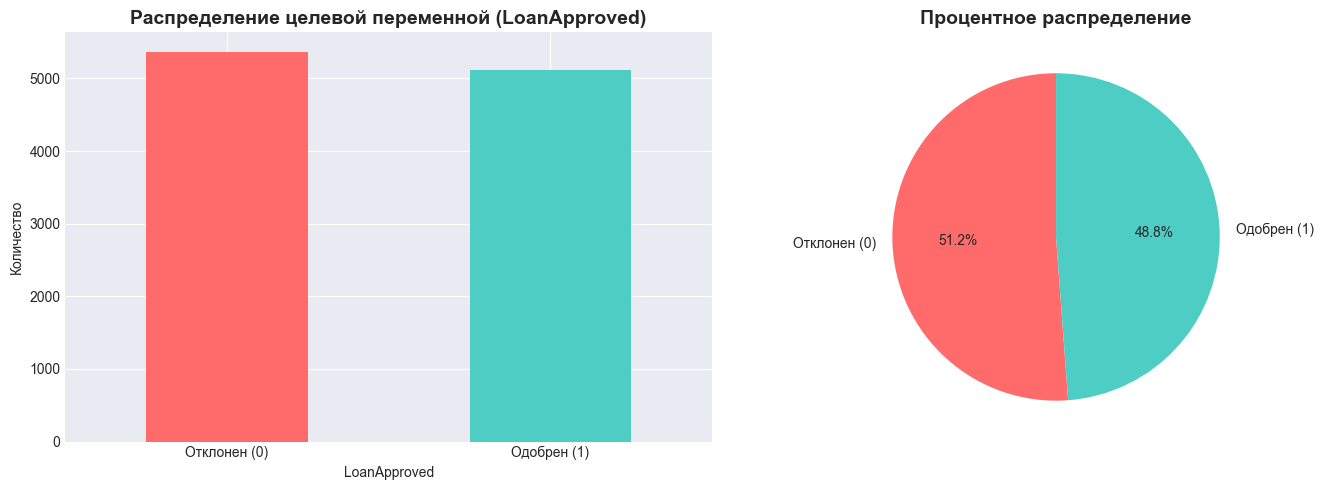

In [97]:
def plot_target_distribution(df):
    """Анализ целевой переменной"""
    print("\n" + "=" * 80)
    print("АНАЛИЗ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ")
    print("=" * 80)

    target_counts = df["LoanApproved"].value_counts()
    print("\nРаспределение целевой переменной:")
    print(target_counts)
    print(f"\nПроцентное соотношение:")
    print(df["LoanApproved"].value_counts(normalize=True) * 100)

    # График распределения целевой переменной
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Столбчатая диаграмма
    target_counts.plot(kind="bar", ax=axes[0], color=["#FF6B6B", "#4ECDC4"])
    axes[0].set_title(
        "Распределение целевой переменной (LoanApproved)",
        fontsize=14,
        fontweight="bold",
    )
    axes[0].set_xlabel("LoanApproved")
    axes[0].set_ylabel("Количество")
    axes[0].set_xticklabels(["Отклонен (0)", "Одобрен (1)"], rotation=0)

    # Круговая диаграмма
    axes[1].pie(
        target_counts,
        labels=["Отклонен (0)", "Одобрен (1)"],
        autopct="%1.1f%%",
        startangle=90,
        colors=["#FF6B6B", "#4ECDC4"],
    )
    axes[1].set_title("Процентное распределение", fontsize=14, fontweight="bold")

    plt.tight_layout()
    plt.show()


plot_target_distribution(train_df)

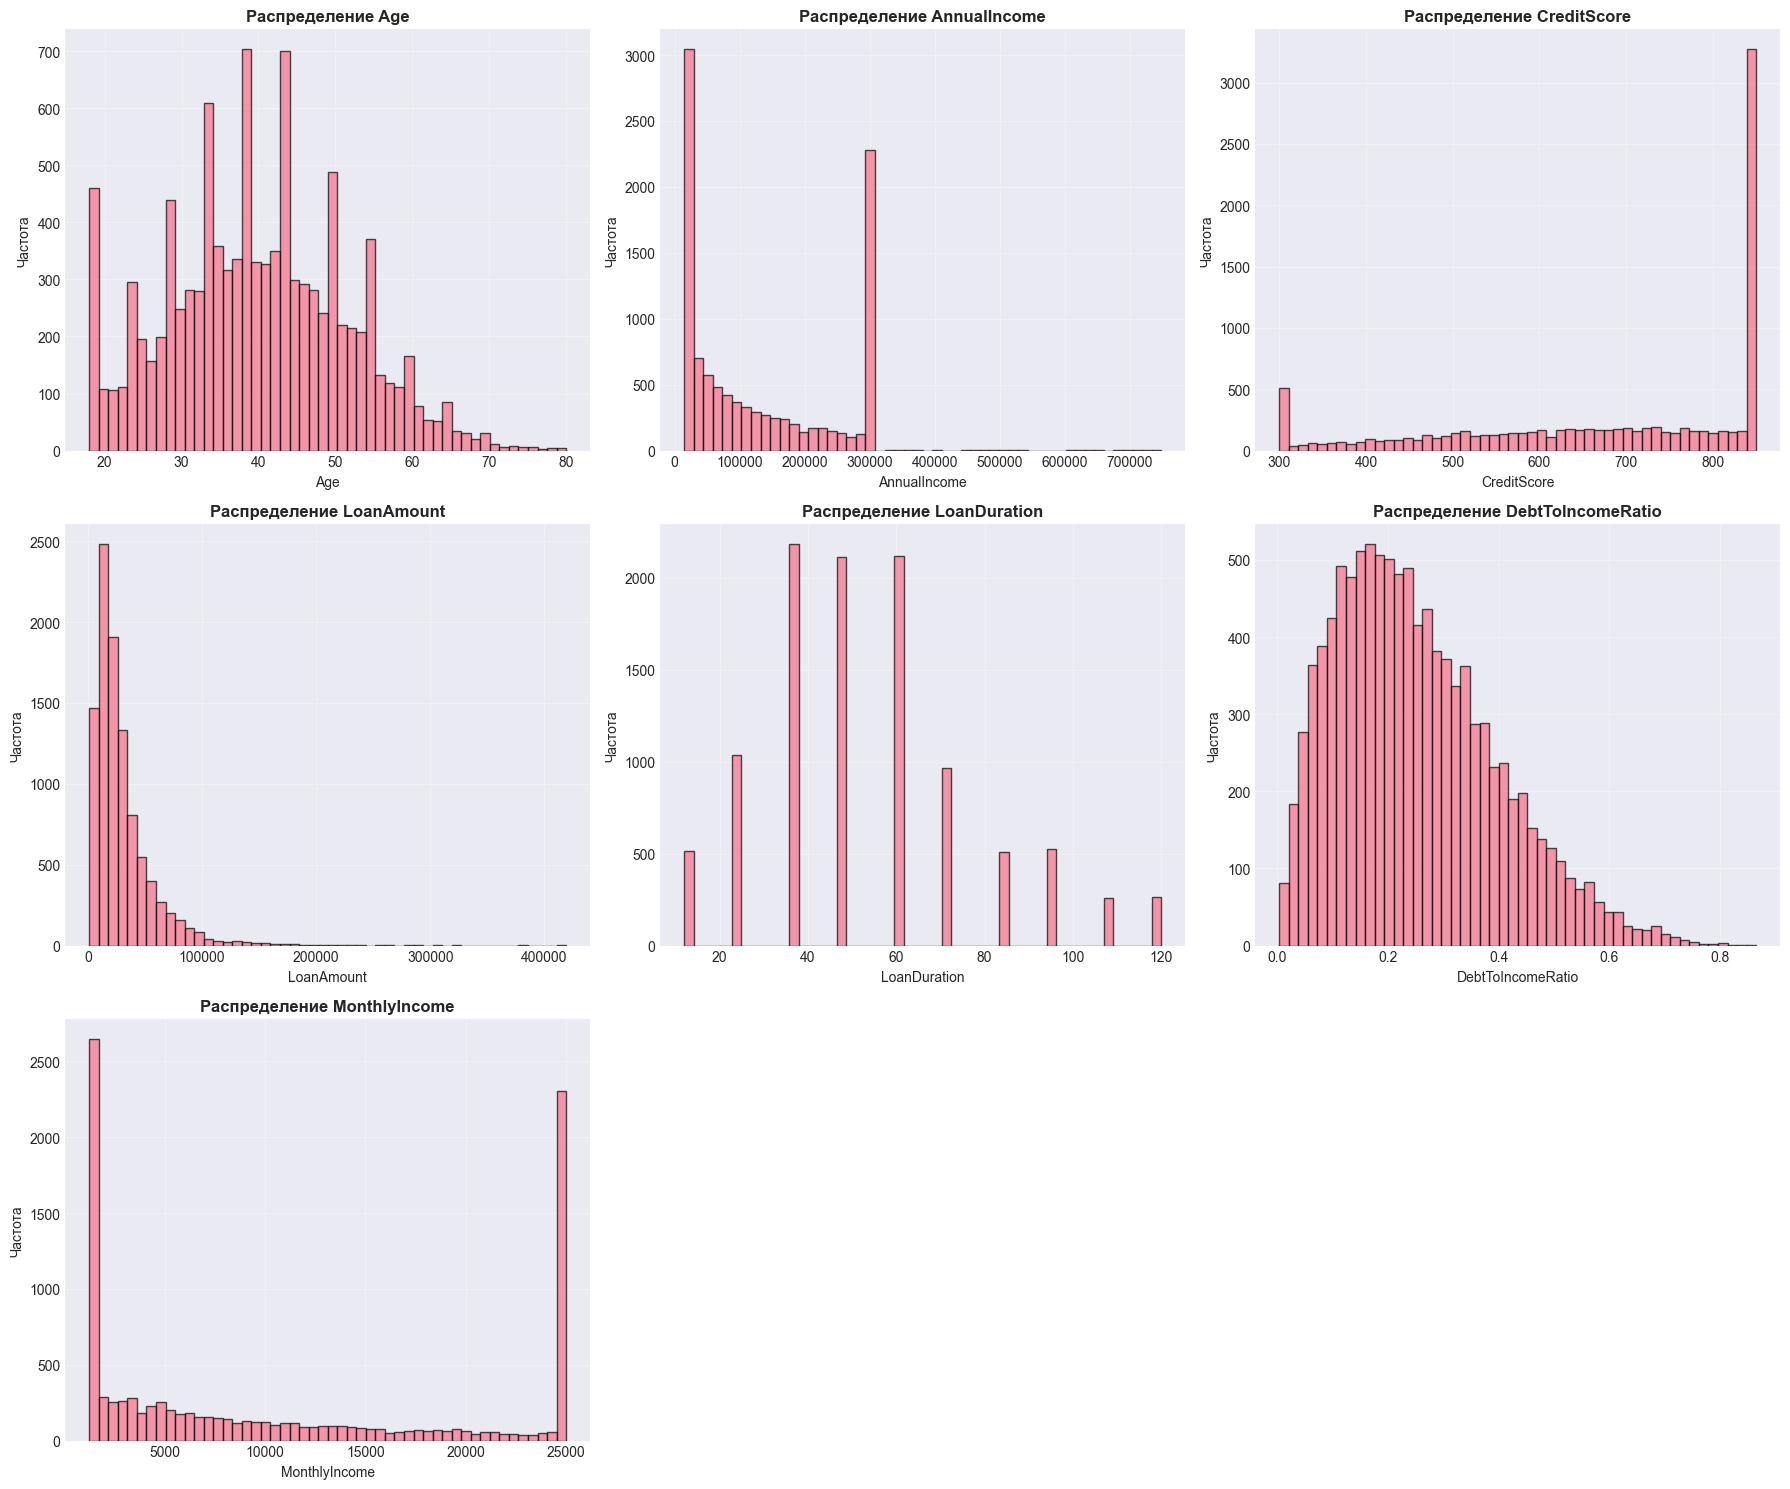

In [98]:
def plot_numerical_features(df):
    # Выбираем числовые признаки
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numerical_cols.remove("LoanApproved")  # Убираем целевую переменную

    # Распределение ключевых числовых признаков
    key_features = [
        "Age",
        "AnnualIncome",
        "CreditScore",
        "LoanAmount",
        "LoanDuration",
        "DebtToIncomeRatio",
        "MonthlyIncome",
    ]

    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    axes = axes.ravel()

    for idx, col in enumerate(key_features):
        if col in df.columns:
            axes[idx].hist(df[col].dropna(), bins=50, edgecolor="black", alpha=0.7)
            axes[idx].set_title(f"Распределение {col}", fontsize=12, fontweight="bold")
            axes[idx].set_xlabel(col)
            axes[idx].set_ylabel("Частота")
            axes[idx].grid(True, alpha=0.3)

    # Удаляем лишние подграфики
    for idx in range(len(key_features), len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()


plot_numerical_features(train_df)

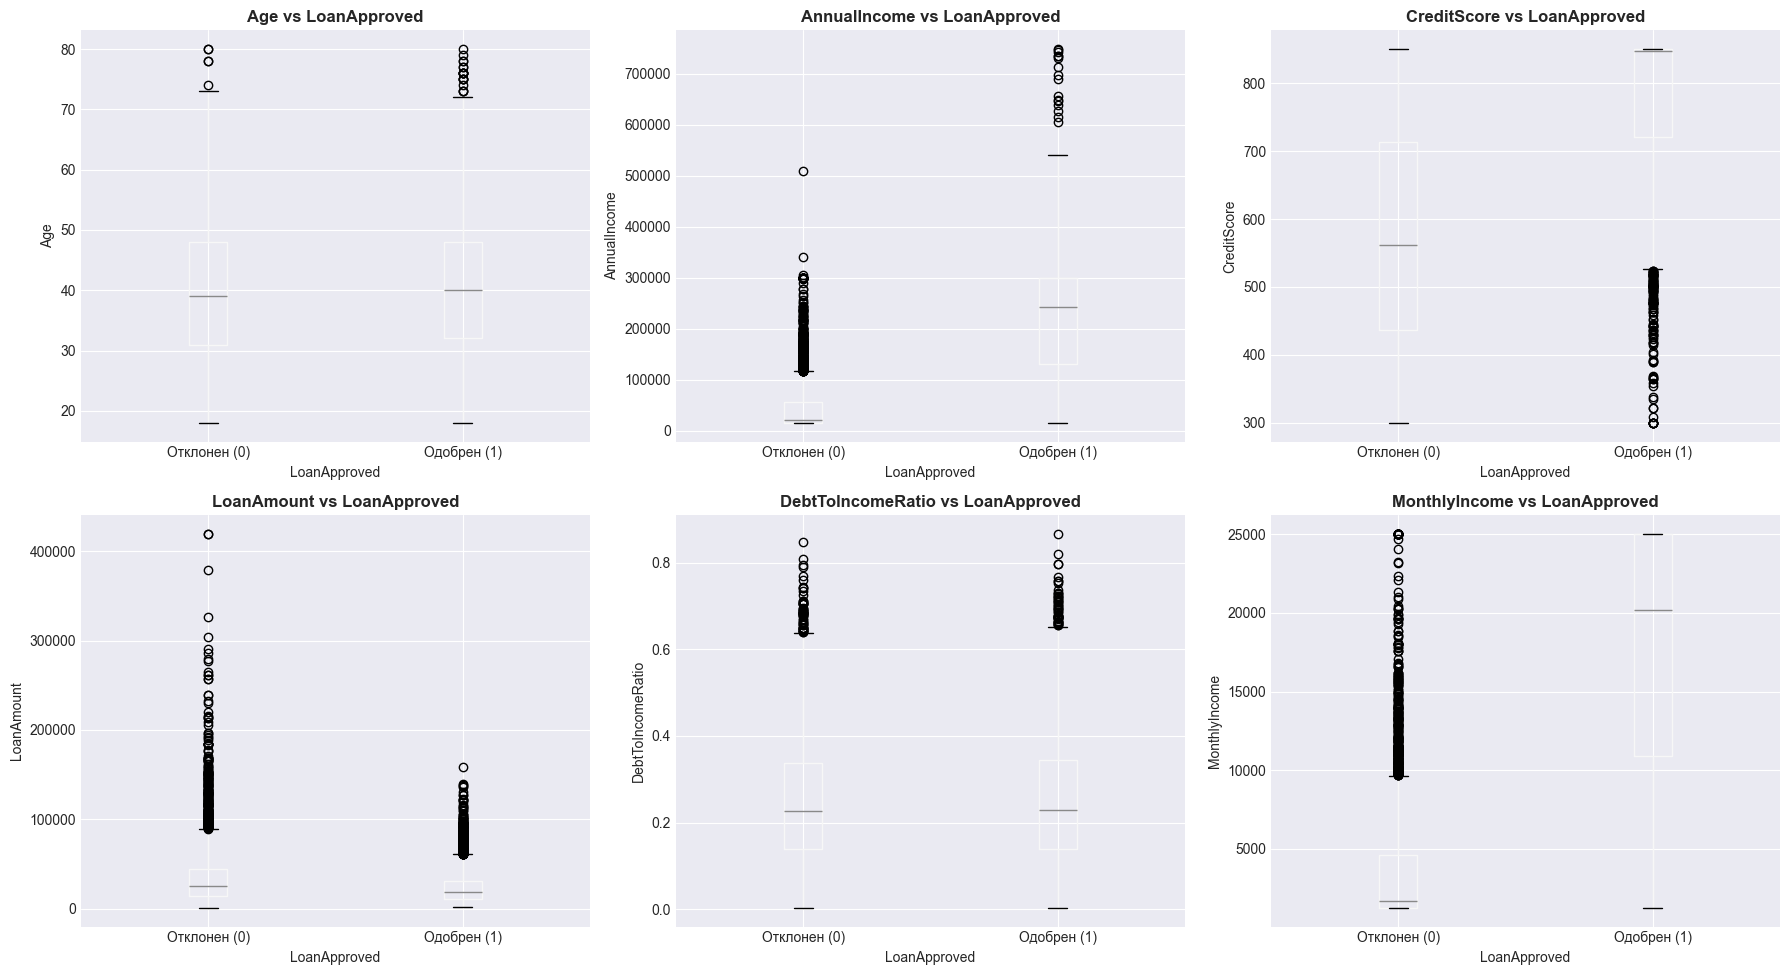

In [99]:
def plot_features_vs_target(df):
    key_features = [
        "Age",
        "AnnualIncome",
        "CreditScore",
        "LoanAmount",
        "DebtToIncomeRatio",
        "MonthlyIncome",
    ]

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.ravel()

    for idx, col in enumerate(key_features):
        if col in df.columns:
            df.boxplot(column=col, by="LoanApproved", ax=axes[idx])
            axes[idx].set_title(
                f"{col} vs LoanApproved", fontsize=12, fontweight="bold"
            )
            axes[idx].set_xlabel("LoanApproved")
            axes[idx].set_ylabel(col)
            plt.sca(axes[idx])
            plt.xticks([1, 2], ["Отклонен (0)", "Одобрен (1)"])

    plt.suptitle("")  # Убираем автоматический заголовок
    plt.tight_layout()
    plt.show()


plot_features_vs_target(train_df)


Корреляция признаков с целевой переменной:
LoanApproved                  1.000000
MonthlyIncome                 0.754853
AnnualIncome                  0.743034
CreditScore                   0.581812
NetWorth                      0.129624
TotalAssets                   0.129204
LengthOfCreditHistory         0.038509
Experience                    0.036699
Age                           0.036580
DebtToIncomeRatio             0.014922
NumberOfCreditInquiries       0.012520
CheckingAccountBalance        0.009503
CreditCardUtilizationRate     0.003731
NumberOfOpenCreditLines      -0.001003
NumberOfDependents           -0.007421
JobTenure                    -0.007951
PaymentHistory               -0.010064
SavingsAccountBalance        -0.011804
TotalLiabilities             -0.015154
UtilityBillsPaymentHistory   -0.020812
PreviousLoanDefaults         -0.029994
LoanDuration                 -0.039908
BankruptcyHistory            -0.042160
MonthlyDebtPayments          -0.044257
LoanAmount          

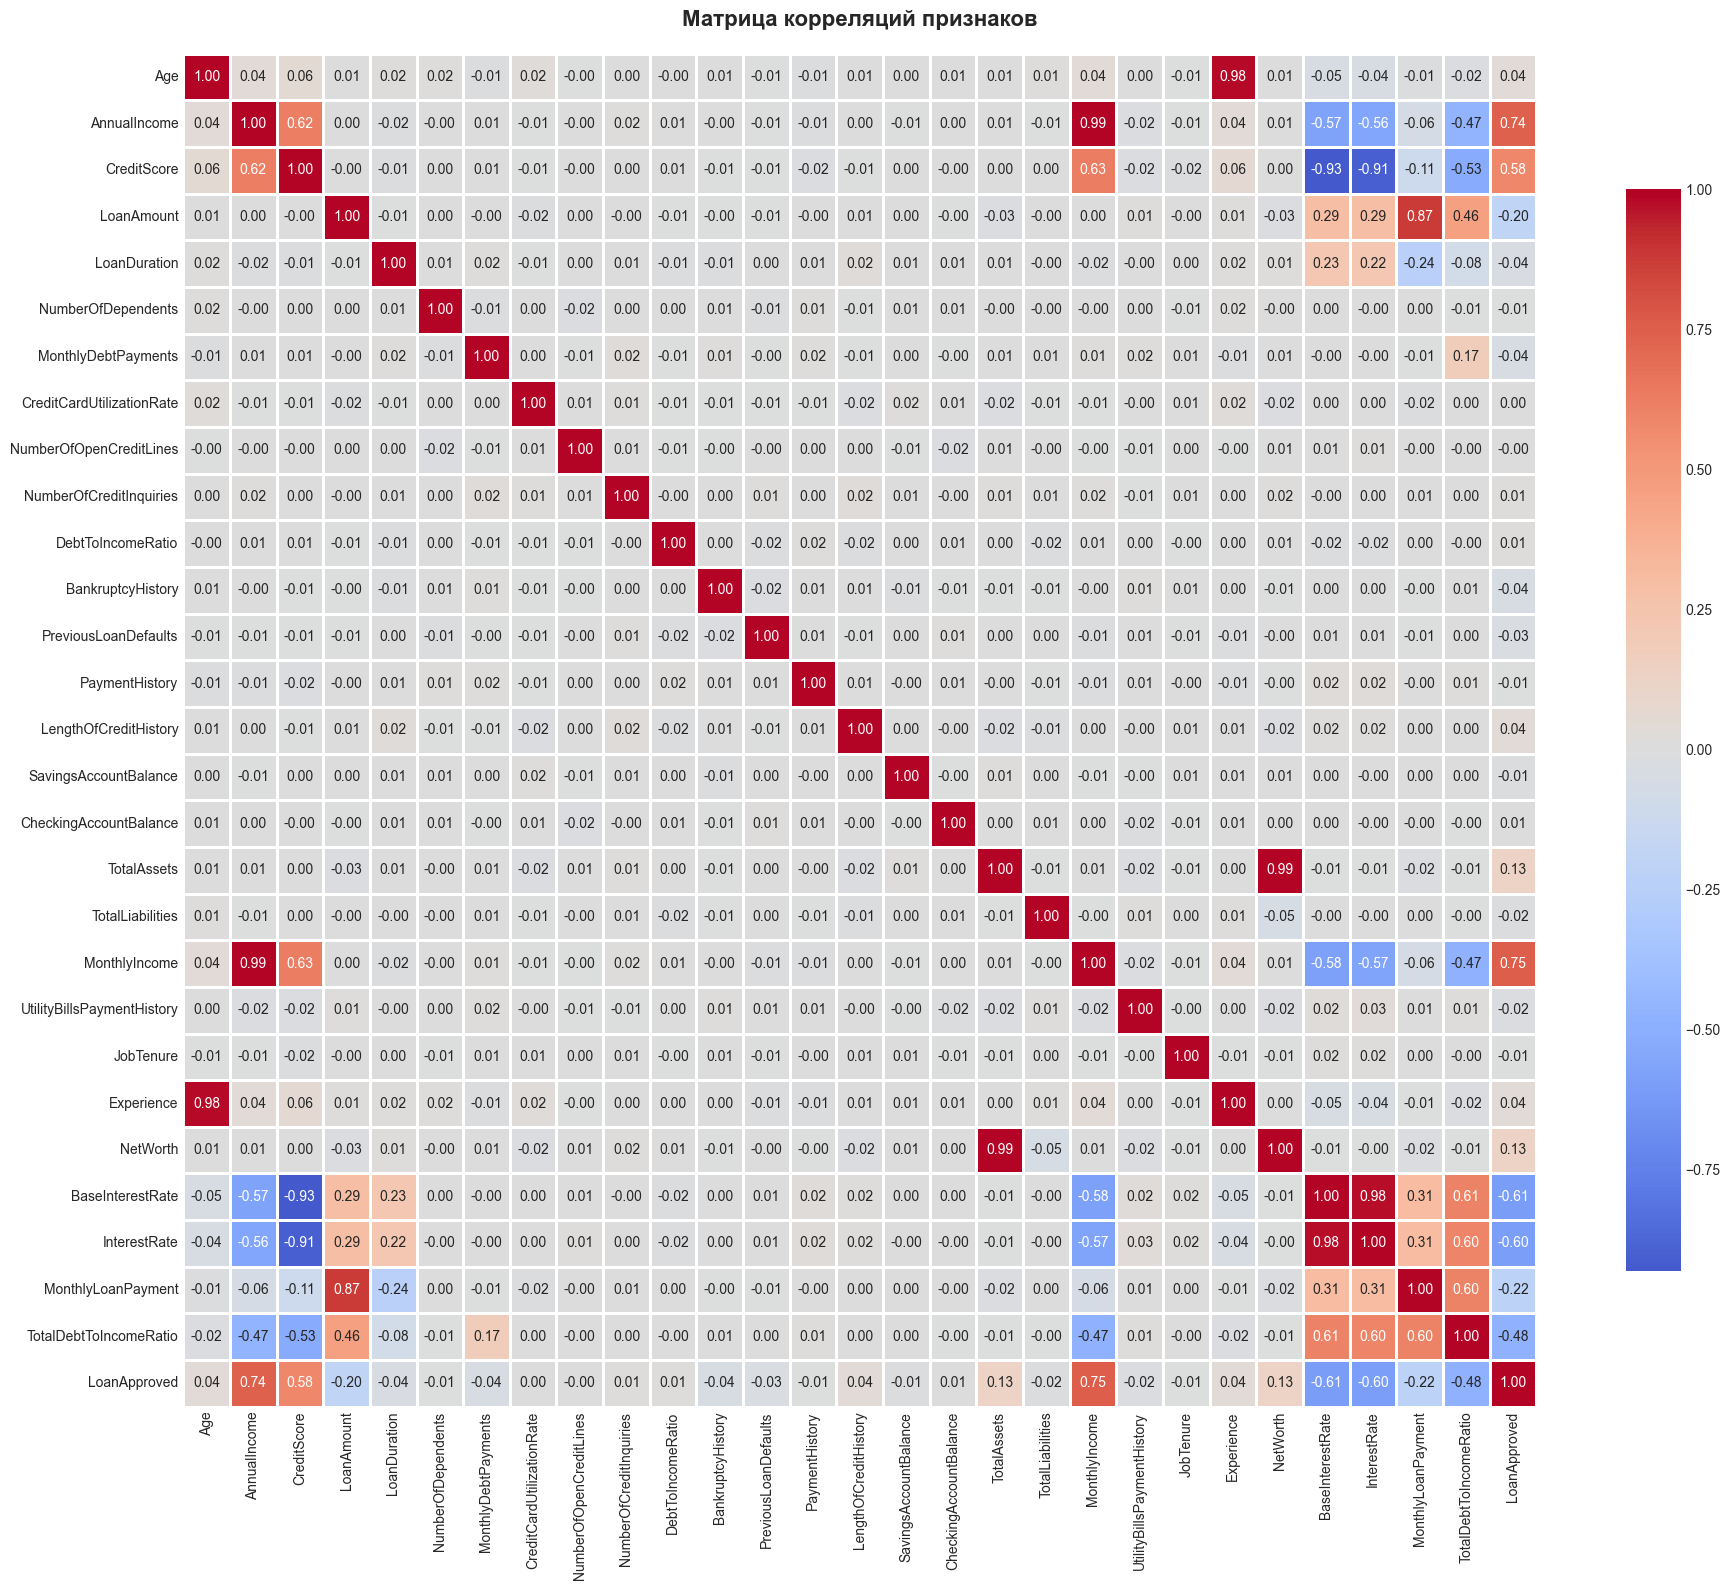


ТОП-10 ПРИЗНАКОВ С НАИБОЛЬШЕЙ КОРРЕЛЯЦИЕЙ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ
LoanApproved               1.000000
MonthlyIncome              0.754853
AnnualIncome               0.743034
CreditScore                0.581812
NetWorth                   0.129624
TotalAssets                0.129204
LengthOfCreditHistory      0.038509
Experience                 0.036699
Age                        0.036580
DebtToIncomeRatio          0.014922
NumberOfCreditInquiries    0.012520
Name: LoanApproved, dtype: float64


In [100]:
def plot_correlation_matrix(df):
    # Выбираем только числовые признаки
    numerical_df = df.select_dtypes(include=[np.number])

    # Вычисляем корреляцию
    correlation_matrix = numerical_df.corr()

    # Корреляция с целевой переменной
    target_corr = correlation_matrix["LoanApproved"].sort_values(ascending=False)
    print("\nКорреляция признаков с целевой переменной:")
    print(target_corr)

    # Визуализация полной матрицы корреляций
    plt.figure(figsize=(20, 16))
    sns.heatmap(
        correlation_matrix,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        center=0,
        square=True,
        linewidths=1,
        cbar_kws={"shrink": 0.8},
    )
    plt.title("Матрица корреляций признаков", fontsize=16, fontweight="bold", pad=20)
    plt.tight_layout()
    plt.show()

    # Топ коррелирующих признаков
    print("\n" + "=" * 80)
    print("ТОП-10 ПРИЗНАКОВ С НАИБОЛЬШЕЙ КОРРЕЛЯЦИЕЙ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ")
    print("=" * 80)
    print(target_corr.head(11))  # 11, потому что первый - сама целевая переменная


plot_correlation_matrix(train_df)

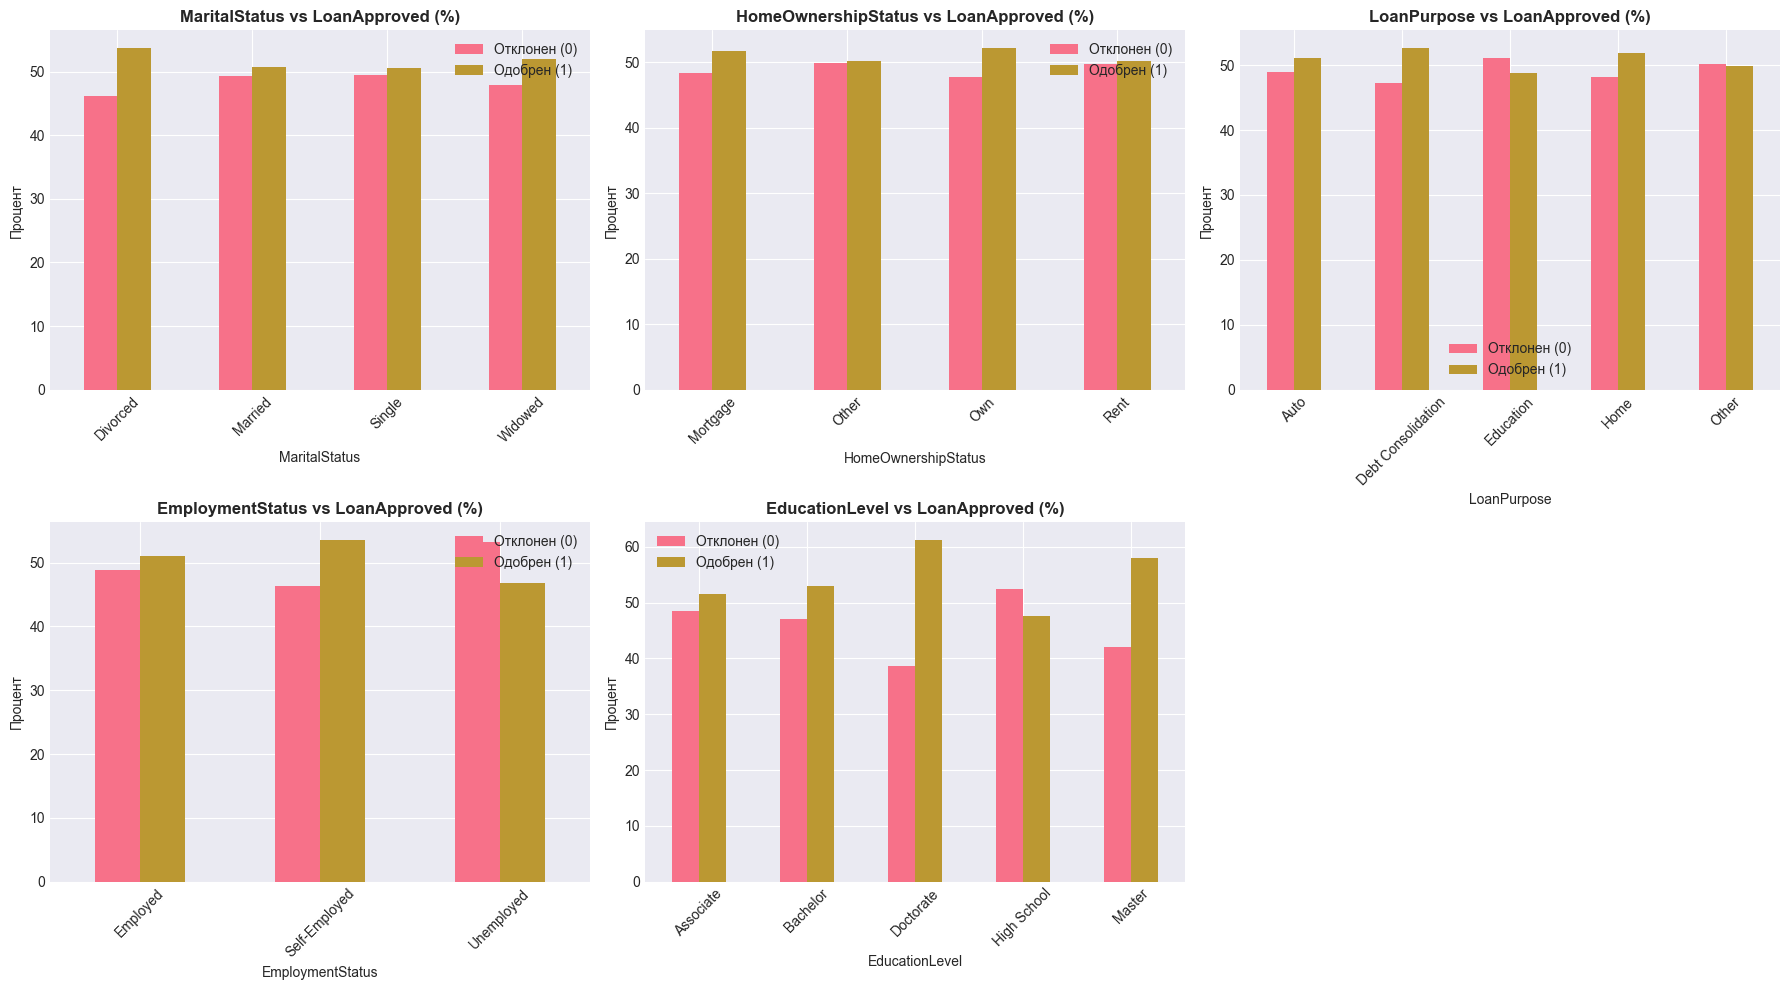

In [101]:
def plot_categorical_features(df):
    categorical_cols = [
        "MaritalStatus",
        "HomeOwnershipStatus",
        "LoanPurpose",
        "EmploymentStatus",
        "EducationLevel",
    ]

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.ravel()

    for idx, col in enumerate(categorical_cols):
        if col in df.columns:
            # Подсчет по категориям и целевой переменной
            cross_tab = (
                pd.crosstab(df[col], df["LoanApproved"], normalize="index") * 100
            )
            cross_tab.plot(kind="bar", ax=axes[idx], stacked=False)
            axes[idx].set_title(
                f"{col} vs LoanApproved (%)", fontsize=12, fontweight="bold"
            )
            axes[idx].set_xlabel(col)
            axes[idx].set_ylabel("Процент")
            axes[idx].legend(["Отклонен (0)", "Одобрен (1)"])
            axes[idx].tick_params(axis="x", rotation=45)

    # Удаляем лишний подграфик
    fig.delaxes(axes[-1])

    plt.tight_layout()
    plt.show()


plot_categorical_features(train_df)

In [102]:
from sklearn.model_selection import train_test_split


def prepare_data(train_df, test_df):
    """Подготовка данных для обучения"""
    print("\n" + "=" * 80)
    print("ПОДГОТОВКА ДАННЫХ ДЛЯ ОБУЧЕНИЯ")
    print("=" * 80)

    # Сохраняем ID из тестового набора
    test_ids = test_df["ID"].copy() if "ID" in test_df.columns else None

    # Создаем копии
    train_processed = train_df.copy()
    test_processed = test_df.copy()

    # Обработка пропущенных значений
    print("\nОбработка пропущенных значений...")

    # Для числовых признаков - заполняем медианой
    numerical_cols = train_processed.select_dtypes(include=[np.number]).columns
    for col in numerical_cols:
        if train_processed[col].isnull().sum() > 0:
            median_value = train_processed[col].median()
            train_processed[col] = train_processed[col].fillna(median_value)
            if col in test_processed.columns:
                test_processed[col] = test_processed[col].fillna(median_value)

    # Для категориальных признаков - заполняем модой
    categorical_cols = train_processed.select_dtypes(include=["object"]).columns
    for col in categorical_cols:
        if col != "ApplicationDate":  # Пропускаем дату
            if train_processed[col].isnull().sum() > 0:
                mode_value = train_processed[col].mode()[0]
                train_processed[col] = train_processed[col].fillna(mode_value)
                if col in test_processed.columns:
                    test_processed[col] = test_processed[col].fillna(mode_value)

    # Кодирование категориальных признаков
    print("\nКодирование категориальных признаков...")
    label_encoders = {}

    for col in categorical_cols:
        if col != "ApplicationDate":
            le = LabelEncoder()
            # Объединяем train и test для консистентного кодирования
            combined = pd.concat([train_processed[col], test_processed[col]], axis=0)
            le.fit(combined)
            train_processed[col] = le.transform(train_processed[col])
            test_processed[col] = le.transform(test_processed[col])
            label_encoders[col] = le

    # Обработка даты
    if "ApplicationDate" in train_processed.columns:
        print("\nОбработка признака ApplicationDate...")
        train_processed["ApplicationDate"] = pd.to_datetime(
            train_processed["ApplicationDate"], errors="coerce"
        )
        test_processed["ApplicationDate"] = pd.to_datetime(
            test_processed["ApplicationDate"], errors="coerce"
        )

        # Извлекаем признаки из даты
        train_processed["ApplicationYear"] = train_processed["ApplicationDate"].dt.year
        train_processed["ApplicationMonth"] = train_processed[
            "ApplicationDate"
        ].dt.month
        train_processed["ApplicationDay"] = train_processed["ApplicationDate"].dt.day

        test_processed["ApplicationYear"] = test_processed["ApplicationDate"].dt.year
        test_processed["ApplicationMonth"] = test_processed["ApplicationDate"].dt.month
        test_processed["ApplicationDay"] = test_processed["ApplicationDate"].dt.day

        # Заполняем NaN в датах медианными значениями
        for col in ["ApplicationYear", "ApplicationMonth", "ApplicationDay"]:
            median_val = train_processed[col].median()
            train_processed[col] = train_processed[col].fillna(median_val)
            if col in test_processed.columns:
                test_processed[col] = test_processed[col].fillna(median_val)

        # Удаляем исходный признак даты
        train_processed = train_processed.drop("ApplicationDate", axis=1)
        test_processed = test_processed.drop("ApplicationDate", axis=1)

    # Разделение на признаки и целевую переменную
    X_train = train_processed.drop("LoanApproved", axis=1)
    y_train = train_processed["LoanApproved"]
    X_test = test_processed.drop(["LoanApproved", "ID"], axis=1, errors="ignore")

    print(f"\nРазмер обучающей выборки: {X_train.shape}")
    print(f"Размер тестовой выборки: {X_test.shape}")
    print(f"Количество признаков: {X_train.shape[1]}")

    # Разделение на train и validation
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    )

    print(f"Размер train: {X_tr.shape}")
    print(f"Размер validation: {X_val.shape}")

    return X_train, y_train, X_test, test_ids, X_tr, X_val, y_tr, y_val


X_train, y_train, X_test, test_ids, X_tr, X_val, y_tr, y_val = prepare_data(
    train_df, test_df
)


ПОДГОТОВКА ДАННЫХ ДЛЯ ОБУЧЕНИЯ

Обработка пропущенных значений...

Кодирование категориальных признаков...

Обработка признака ApplicationDate...

Размер обучающей выборки: (11017, 36)
Размер тестовой выборки: (5000, 36)
Количество признаков: 36
Размер train: (8813, 36)
Размер validation: (2204, 36)


# Бэггинг

In [103]:
class CustomBagging:
    """
    Реализация алгоритма Bagging (Bootstrap Aggregating)
    """

    def __init__(
        self,
        base_estimator=None,
        n_estimators=10,
        max_samples=1.0,
        random_state=None,
        bootstrap=True,
    ):
        """
        Args:
            base_estimator: базовая модель (по умолчанию DecisionTreeClassifier)
            n_estimators: количество базовых моделей
            max_samples: доля выборки для каждой модели
            random_state: seed для воспроизводимости
            bootstrap: использовать ли bootstrap выборку
        """
        self.base_estimator = (
            base_estimator if base_estimator else DecisionTreeClassifier()
        )
        self.n_estimators = n_estimators
        self.max_samples = max_samples
        self.random_state = random_state
        self.bootstrap = bootstrap
        self.estimators_ = []

    def fit(self, X, y):
        """
        Обучение ансамбля

        Args:
            X: признаки
            y: целевая переменная
        """
        np.random.seed(self.random_state)
        self.estimators_ = []

        n_samples = X.shape[0]
        max_samples = int(n_samples * self.max_samples)

        for i in range(self.n_estimators):
            # Создаем копию базовой модели
            estimator = clone(self.base_estimator)

            # Генерируем bootstrap выборку
            if self.bootstrap:
                indices = np.random.choice(n_samples, size=max_samples, replace=True)
            else:
                indices = np.random.choice(n_samples, size=max_samples, replace=False)

            X_sample = X[indices] if isinstance(X, np.ndarray) else X.iloc[indices]
            y_sample = y[indices] if isinstance(y, np.ndarray) else y.iloc[indices]

            # Обучаем модель
            estimator.fit(X_sample, y_sample)
            self.estimators_.append(estimator)

        return self

    def predict(self, X):
        """
        Предсказание классов

        Args:
            X: признаки

        Returns:
            array: предсказанные классы
        """
        # Получаем предсказания от всех моделей
        predictions = np.array([estimator.predict(X) for estimator in self.estimators_])

        # Голосование большинством
        final_predictions = np.apply_along_axis(
            lambda x: np.bincount(x.astype(int)).argmax(), axis=0, arr=predictions
        )

        return final_predictions

    def predict_proba(self, X):
        """
        Предсказание вероятностей классов

        Args:
            X: признаки

        Returns:
            array: предсказанные вероятности
        """
        # Получаем вероятности от всех моделей
        probas = np.array(
            [estimator.predict_proba(X) for estimator in self.estimators_]
        )

        # Усредняем вероятности
        avg_probas = np.mean(probas, axis=0)

        return avg_probas

# Градиентный бустинг

In [104]:
class CustomGradientBoosting:
    """
    Реализация алгоритма Gradient Boosting для бинарной классификации
    """

    def __init__(
        self,
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        min_samples_split=2,
        random_state=None,
    ):
        """
        Args:
            n_estimators: количество деревьев
            learning_rate: скорость обучения
            max_depth: максимальная глубина деревьев
            min_samples_split: минимальное количество образцов для разбиения
            random_state: seed для воспроизводимости
        """
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.random_state = random_state
        self.estimators_ = []
        self.init_prediction_ = None

    def _sigmoid(self, x):
        """Сигмоидная функция"""
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

    def _log_loss_gradient(self, y, y_pred):
        """Градиент log loss"""
        return y - self._sigmoid(y_pred)

    def fit(self, X, y):
        """
        Обучение ансамбля

        Args:
            X: признаки
            y: целевая переменная
        """
        np.random.seed(self.random_state)
        self.estimators_ = []

        # Конвертируем в numpy array
        X = np.array(X) if not isinstance(X, np.ndarray) else X
        y = np.array(y) if not isinstance(y, np.ndarray) else y

        # Инициализация: log(odds)
        pos_count = np.sum(y == 1)
        neg_count = np.sum(y == 0)
        self.init_prediction_ = np.log(pos_count / neg_count) if neg_count > 0 else 0.0

        # Текущие предсказания (в логитах)
        current_predictions = np.full(len(y), self.init_prediction_)

        # Итеративное обучение деревьев
        for i in range(self.n_estimators):
            # Вычисляем градиент (остатки)
            residuals = self._log_loss_gradient(y, current_predictions)

            # Обучаем дерево регрессии на остатках
            tree = DecisionTreeRegressor(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                random_state=self.random_state + i if self.random_state else None,
            )
            tree.fit(X, residuals)

            # Обновляем предсказания
            update = tree.predict(X)
            current_predictions += self.learning_rate * update

            # Сохраняем дерево
            self.estimators_.append(tree)

        return self

    def _predict_raw(self, X):
        """Предсказание в логитах"""
        X = np.array(X) if not isinstance(X, np.ndarray) else X

        # Начальное предсказание
        predictions = np.full(X.shape[0], self.init_prediction_)

        # Добавляем предсказания от каждого дерева
        for tree in self.estimators_:
            predictions += self.learning_rate * tree.predict(X)

        return predictions

    def predict_proba(self, X):
        """
        Предсказание вероятностей классов

        Args:
            X: признаки

        Returns:
            array: предсказанные вероятности
        """
        raw_predictions = self._predict_raw(X)
        proba_positive = self._sigmoid(raw_predictions)

        # Возвращаем вероятности для обоих классов
        return np.vstack([1 - proba_positive, proba_positive]).T

    def predict(self, X):
        """
        Предсказание классов

        Args:
            X: признаки

        Returns:
            array: предсказанные классы
        """
        proba = self.predict_proba(X)
        return (proba[:, 1] >= 0.5).astype(int)

# Accuracy

In [105]:
class CustomAccuracy:
    """Реализация метрики Accuracy"""

    @staticmethod
    def calculate(y_true, y_pred):
        """
        Вычисление Accuracy

        Accuracy = (TP + TN) / (TP + TN + FP + FN)

        Args:
            y_true: истинные метки
            y_pred: предсказанные метки

        Returns:
            float: значение accuracy
        """
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        correct = np.sum(y_true == y_pred)
        total = len(y_true)

        return correct / total if total > 0 else 0.0

# Precision

In [106]:
class CustomPrecision:
    """Реализация метрики Precision"""

    @staticmethod
    def calculate(y_true, y_pred, average="binary", pos_label=1):
        """
        Вычисление Precision

        Precision = TP / (TP + FP)

        Args:
            y_true: истинные метки
            y_pred: предсказанные метки
            average: тип усреднения ('binary', 'macro', 'micro', 'weighted')
            pos_label: положительный класс для binary

        Returns:
            float: значение precision
        """
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        if average == "binary":
            tp = np.sum((y_true == pos_label) & (y_pred == pos_label))
            fp = np.sum((y_true != pos_label) & (y_pred == pos_label))

            return tp / (tp + fp) if (tp + fp) > 0 else 0.0

        elif average == "macro":
            classes = np.unique(y_true)
            precisions = []
            for cls in classes:
                tp = np.sum((y_true == cls) & (y_pred == cls))
                fp = np.sum((y_true != cls) & (y_pred == cls))
                precisions.append(tp / (tp + fp) if (tp + fp) > 0 else 0.0)
            return np.mean(precisions)

        elif average == "micro":
            tp = np.sum(y_true == y_pred)
            fp = np.sum(y_true != y_pred)
            return tp / (tp + fp) if (tp + fp) > 0 else 0.0

        elif average == "weighted":
            classes = np.unique(y_true)
            precisions = []
            weights = []
            for cls in classes:
                tp = np.sum((y_true == cls) & (y_pred == cls))
                fp = np.sum((y_true != cls) & (y_pred == cls))
                precisions.append(tp / (tp + fp) if (tp + fp) > 0 else 0.0)
                weights.append(np.sum(y_true == cls))
            return np.average(precisions, weights=weights)

        else:
            raise ValueError(f"Unknown average type: {average}")

# Recall

In [107]:
class CustomRecall:
    """Реализация метрики Recall"""

    @staticmethod
    def calculate(y_true, y_pred, average="binary", pos_label=1):
        """
        Вычисление Recall

        Recall = TP / (TP + FN)

        Args:
            y_true: истинные метки
            y_pred: предсказанные метки
            average: тип усреднения ('binary', 'macro', 'micro', 'weighted')
            pos_label: положительный класс для binary

        Returns:
            float: значение recall
        """
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        if average == "binary":
            tp = np.sum((y_true == pos_label) & (y_pred == pos_label))
            fn = np.sum((y_true == pos_label) & (y_pred != pos_label))

            return tp / (tp + fn) if (tp + fn) > 0 else 0.0

        elif average == "macro":
            classes = np.unique(y_true)
            recalls = []
            for cls in classes:
                tp = np.sum((y_true == cls) & (y_pred == cls))
                fn = np.sum((y_true == cls) & (y_pred != cls))
                recalls.append(tp / (tp + fn) if (tp + fn) > 0 else 0.0)
            return np.mean(recalls)

        elif average == "micro":
            tp = np.sum(y_true == y_pred)
            fn = np.sum(y_true != y_pred)
            return tp / (tp + fn) if (tp + fn) > 0 else 0.0

        elif average == "weighted":
            classes = np.unique(y_true)
            recalls = []
            weights = []
            for cls in classes:
                tp = np.sum((y_true == cls) & (y_pred == cls))
                fn = np.sum((y_true == cls) & (y_pred != cls))
                recalls.append(tp / (tp + fn) if (tp + fn) > 0 else 0.0)
                weights.append(np.sum(y_true == cls))
            return np.average(recalls, weights=weights)

        else:
            raise ValueError(f"Unknown average type: {average}")

# F1

In [108]:
class CustomF1Score:
    """Реализация метрики F1-Score"""

    @staticmethod
    def calculate(y_true, y_pred, average="binary", pos_label=1):
        """
        Вычисление F1-Score

        F1 = 2 * (Precision * Recall) / (Precision + Recall)

        Args:
            y_true: истинные метки
            y_pred: предсказанные метки
            average: тип усреднения ('binary', 'macro', 'micro', 'weighted')
            pos_label: положительный класс для binary

        Returns:
            float: значение f1-score
        """
        precision = CustomPrecision.calculate(y_true, y_pred, average, pos_label)
        recall = CustomRecall.calculate(y_true, y_pred, average, pos_label)

        if precision + recall == 0:
            return 0.0

        return 2 * (precision * recall) / (precision + recall)

# AUC-ROC

In [109]:
class CustomROCAUC:
    """Реализация метрики ROC-AUC"""

    @staticmethod
    def calculate(y_true, y_scores):
        """
        Вычисление ROC-AUC

        Args:
            y_true: истинные метки
            y_scores: предсказанные вероятности положительного класса

        Returns:
            float: значение ROC-AUC
        """
        y_true = np.array(y_true)
        y_scores = np.array(y_scores)

        # Сортируем по убыванию scores
        desc_score_indices = np.argsort(y_scores)[::-1]
        y_true_sorted = y_true[desc_score_indices]
        y_scores_sorted = y_scores[desc_score_indices]

        # Находим уникальные пороги
        distinct_value_indices = np.where(np.diff(y_scores_sorted))[0]
        threshold_idxs = np.r_[distinct_value_indices, y_true.size - 1]

        # Вычисляем TPR и FPR
        tps = np.cumsum(y_true_sorted)[threshold_idxs]
        fps = 1 + threshold_idxs - tps

        # Добавляем начальную точку (0, 0)
        tps = np.r_[0, tps]
        fps = np.r_[0, fps]

        # Нормализуем
        if tps[-1] == 0 or fps[-1] == 0:
            return 0.5

        fpr = fps / fps[-1]
        tpr = tps / tps[-1]

        # Вычисляем площадь под кривой методом трапеций
        auc = np.trapezoid(tpr, fpr)

        return auc

# AUC-PR

In [110]:
class CustomPRAUC:
    """Реализация метрики PR-AUC (Precision-Recall AUC)"""
    
    @staticmethod
    def calculate(y_true, y_scores):
        """
        Вычисление PR-AUC (Average Precision)

        Args:
            y_true: истинные метки
            y_scores: предсказанные вероятности положительного класса

        Returns:
            float: значение PR-AUC
        """
        y_true = np.array(y_true)
        y_scores = np.array(y_scores)
        
        # Сортируем по убыванию scores
        desc_score_indices = np.argsort(y_scores)[::-1]
        y_true_sorted = y_true[desc_score_indices]
        
        # Вычисляем precision на каждом шаге
        tp_sum = np.cumsum(y_true_sorted)
        
        # Precision на каждом пороге
        precisions = tp_sum / np.arange(1, len(y_true_sorted) + 1)
        
        # Average Precision - среднее precision для всех положительных примеров
        # взвешенное по изменению recall
        ap = np.sum(precisions * y_true_sorted) / np.sum(y_true_sorted)
        
        return ap

# Сравнение метрик с sklearn

In [111]:
def test_metrics():
    """Тестирование реализованных метрик"""
    from sklearn.metrics import (
        accuracy_score,
        precision_score,
        recall_score,
        f1_score,
        roc_auc_score,
        average_precision_score,
    )

    print("=" * 80)
    print("ТЕСТИРОВАНИЕ МЕТРИК")
    print("=" * 80)

    # Тестовые данные
    y_true = np.array([0, 1, 1, 0, 1, 0, 1, 1, 0, 1])
    y_pred = np.array([0, 1, 0, 0, 1, 0, 1, 1, 1, 1])
    y_scores = np.array([0.1, 0.9, 0.4, 0.2, 0.8, 0.3, 0.7, 0.85, 0.6, 0.95])

    print("\nТестовые данные:")
    print(f"y_true:   {y_true}")
    print(f"y_pred:   {y_pred}")
    print(f"y_scores: {y_scores}")

    # Accuracy
    print("\n" + "-" * 80)
    print("ACCURACY")
    print("-" * 80)
    custom_acc = CustomAccuracy.calculate(y_true, y_pred)
    sklearn_acc = accuracy_score(y_true, y_pred)
    print(f"Custom Accuracy:  {custom_acc:.6f}")
    print(f"Sklearn Accuracy: {sklearn_acc:.6f}")
    print(f"Разница: {abs(custom_acc - sklearn_acc):.10f}")

    # Precision
    print("\n" + "-" * 80)
    print("PRECISION")
    print("-" * 80)
    custom_prec = CustomPrecision.calculate(y_true, y_pred)
    sklearn_prec = precision_score(y_true, y_pred)
    print(f"Custom Precision:  {custom_prec:.6f}")
    print(f"Sklearn Precision: {sklearn_prec:.6f}")
    print(f"Разница: {abs(custom_prec - sklearn_prec):.10f}")

    # Recall
    print("\n" + "-" * 80)
    print("RECALL")
    print("-" * 80)
    custom_rec = CustomRecall.calculate(y_true, y_pred)
    sklearn_rec = recall_score(y_true, y_pred)
    print(f"Custom Recall:  {custom_rec:.6f}")
    print(f"Sklearn Recall: {sklearn_rec:.6f}")
    print(f"Разница: {abs(custom_rec - sklearn_rec):.10f}")

    # F1-Score
    print("\n" + "-" * 80)
    print("F1-SCORE")
    print("-" * 80)
    custom_f1 = CustomF1Score.calculate(y_true, y_pred)
    sklearn_f1 = f1_score(y_true, y_pred)
    print(f"Custom F1-Score:  {custom_f1:.6f}")
    print(f"Sklearn F1-Score: {sklearn_f1:.6f}")
    print(f"Разница: {abs(custom_f1 - sklearn_f1):.10f}")

    # ROC-AUC
    print("\n" + "-" * 80)
    print("ROC-AUC")
    print("-" * 80)
    custom_roc = CustomROCAUC.calculate(y_true, y_scores)
    sklearn_roc = roc_auc_score(y_true, y_scores)
    print(f"Custom ROC-AUC:  {custom_roc:.6f}")
    print(f"Sklearn ROC-AUC: {sklearn_roc:.6f}")
    print(f"Разница: {abs(custom_roc - sklearn_roc):.10f}")

    # PR-AUC
    print("\n" + "-" * 80)
    print("PR-AUC")
    print("-" * 80)
    custom_pr = CustomPRAUC.calculate(y_true, y_scores)
    sklearn_pr = average_precision_score(y_true, y_scores)
    print(f"Custom PR-AUC:  {custom_pr:.6f}")
    print(f"Sklearn PR-AUC: {sklearn_pr:.6f}")
    print(f"Разница: {abs(custom_pr - sklearn_pr):.10f}")

    print("\n" + "=" * 80)
    print("ВСЕ МЕТРИКИ ПРОТЕСТИРОВАНЫ УСПЕШНО!")
    print("=" * 80)


test_metrics()

ТЕСТИРОВАНИЕ МЕТРИК

Тестовые данные:
y_true:   [0 1 1 0 1 0 1 1 0 1]
y_pred:   [0 1 0 0 1 0 1 1 1 1]
y_scores: [0.1  0.9  0.4  0.2  0.8  0.3  0.7  0.85 0.6  0.95]

--------------------------------------------------------------------------------
ACCURACY
--------------------------------------------------------------------------------
Custom Accuracy:  0.800000
Sklearn Accuracy: 0.800000
Разница: 0.0000000000

--------------------------------------------------------------------------------
PRECISION
--------------------------------------------------------------------------------
Custom Precision:  0.833333
Sklearn Precision: 0.833333
Разница: 0.0000000000

--------------------------------------------------------------------------------
RECALL
--------------------------------------------------------------------------------
Custom Recall:  0.833333
Sklearn Recall: 0.833333
Разница: 0.0000000000

--------------------------------------------------------------------------------
F1-SCORE
----

# Сравнение реализации Bagging с sklearn 


Обучение Custom Bagging...
Обучение Sklearn Bagging...

--------------------------------------------------------------------------------
РЕЗУЛЬТАТЫ CUSTOM BAGGING:
--------------------------------------------------------------------------------
Accuracy:  0.929220
Precision: 0.928094
Recall:    0.940678
F1-Score:  0.934343
ROC-AUC:   0.980296
PR-AUC:    0.983380

--------------------------------------------------------------------------------
РЕЗУЛЬТАТЫ SKLEARN BAGGING:
--------------------------------------------------------------------------------
Accuracy:  0.927405
Precision: 0.923588
Recall:    0.942373
F1-Score:  0.932886
ROC-AUC:   0.979808
PR-AUC:    0.983220


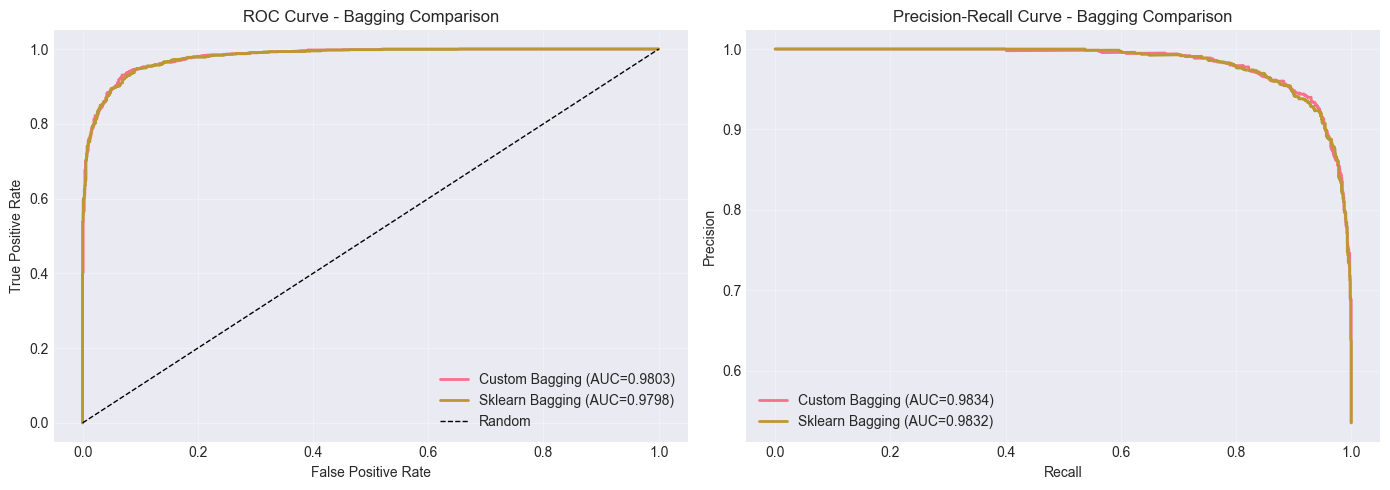

In [113]:
def compare_bagging(X_train, X_val, y_train, y_val):
    """Сравнение реализации Bagging с sklearn"""

    # Параметры
    n_estimators = 50
    random_state = 42

    # Наша реализация
    print("\nОбучение Custom Bagging...")
    custom_bagging = CustomBagging(
        base_estimator=DecisionTreeClassifier(max_depth=10, random_state=random_state),
        n_estimators=n_estimators,
        random_state=random_state,
    )
    custom_bagging.fit(X_train.values, y_train)

    # Sklearn реализация
    print("Обучение Sklearn Bagging...")
    sklearn_bagging = BaggingClassifier(
        estimator=DecisionTreeClassifier(max_depth=10, random_state=random_state),
        n_estimators=n_estimators,
        random_state=random_state,
    )
    sklearn_bagging.fit(X_train, y_train)

    # Предсказания
    custom_pred = custom_bagging.predict(X_val.values)
    custom_proba = custom_bagging.predict_proba(X_val.values)[:, 1]

    sklearn_pred = sklearn_bagging.predict(X_val)
    sklearn_proba = sklearn_bagging.predict_proba(X_val)[:, 1]

    # Метрики
    print("\n" + "-" * 80)
    print("РЕЗУЛЬТАТЫ CUSTOM BAGGING:")
    print("-" * 80)
    print(f"Accuracy:  {CustomAccuracy.calculate(y_val, custom_pred):.6f}")
    print(f"Precision: {CustomPrecision.calculate(y_val, custom_pred):.6f}")
    print(f"Recall:    {CustomRecall.calculate(y_val, custom_pred):.6f}")
    print(f"F1-Score:  {CustomF1Score.calculate(y_val, custom_pred):.6f}")
    print(f"ROC-AUC:   {CustomROCAUC.calculate(y_val, custom_proba):.6f}")
    print(f"PR-AUC:    {CustomPRAUC.calculate(y_val, custom_proba):.6f}")

    print("\n" + "-" * 80)
    print("РЕЗУЛЬТАТЫ SKLEARN BAGGING:")
    print("-" * 80)
    print(f"Accuracy:  {CustomAccuracy.calculate(y_val, sklearn_pred):.6f}")
    print(f"Precision: {CustomPrecision.calculate(y_val, sklearn_pred):.6f}")
    print(f"Recall:    {CustomRecall.calculate(y_val, sklearn_pred):.6f}")
    print(f"F1-Score:  {CustomF1Score.calculate(y_val, sklearn_pred):.6f}")
    print(f"ROC-AUC:   {CustomROCAUC.calculate(y_val, sklearn_proba):.6f}")
    print(f"PR-AUC:    {CustomPRAUC.calculate(y_val, sklearn_proba):.6f}")

    # Визуализация ROC кривых
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # ROC кривая
    fpr_custom, tpr_custom, _ = roc_curve(y_val, custom_proba)
    fpr_sklearn, tpr_sklearn, _ = roc_curve(y_val, sklearn_proba)

    axes[0].plot(
        fpr_custom,
        tpr_custom,
        label=f"Custom Bagging (AUC={CustomROCAUC.calculate(y_val, custom_proba):.4f})",
        linewidth=2,
    )
    axes[0].plot(
        fpr_sklearn,
        tpr_sklearn,
        label=f"Sklearn Bagging (AUC={CustomROCAUC.calculate(y_val, sklearn_proba):.4f})",
        linewidth=2,
    )
    axes[0].plot([0, 1], [0, 1], "k--", label="Random", linewidth=1)
    axes[0].set_xlabel("False Positive Rate")
    axes[0].set_ylabel("True Positive Rate")
    axes[0].set_title("ROC Curve - Bagging Comparison")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # PR кривая
    precision_custom, recall_custom, _ = precision_recall_curve(y_val, custom_proba)
    precision_sklearn, recall_sklearn, _ = precision_recall_curve(y_val, sklearn_proba)

    axes[1].plot(
        recall_custom,
        precision_custom,
        label=f"Custom Bagging (AUC={CustomPRAUC.calculate(y_val, custom_proba):.4f})",
        linewidth=2,
    )
    axes[1].plot(
        recall_sklearn,
        precision_sklearn,
        label=f"Sklearn Bagging (AUC={CustomPRAUC.calculate(y_val, sklearn_proba):.4f})",
        linewidth=2,
    )
    axes[1].set_xlabel("Recall")
    axes[1].set_ylabel("Precision")
    axes[1].set_title("Precision-Recall Curve - Bagging Comparison")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return custom_bagging, sklearn_bagging


custom_bagging, sklearn_bagging = compare_bagging(X_tr, X_val, y_tr, y_val)

# Сравнение реализации Gradient Boosting с sklearn


Обучение Custom Gradient Boosting...
Обучение Sklearn Gradient Boosting...

--------------------------------------------------------------------------------
РЕЗУЛЬТАТЫ CUSTOM GRADIENT BOOSTING:
--------------------------------------------------------------------------------
Accuracy:  0.920145
Precision: 0.916944
Recall:    0.935593
F1-Score:  0.926174
ROC-AUC:   0.976636
PR-AUC:    0.980208

--------------------------------------------------------------------------------
РЕЗУЛЬТАТЫ SKLEARN GRADIENT BOOSTING:
--------------------------------------------------------------------------------
Accuracy:  0.926951
Precision: 0.929233
Recall:    0.934746
F1-Score:  0.931981
ROC-AUC:   0.982232
PR-AUC:    0.985232


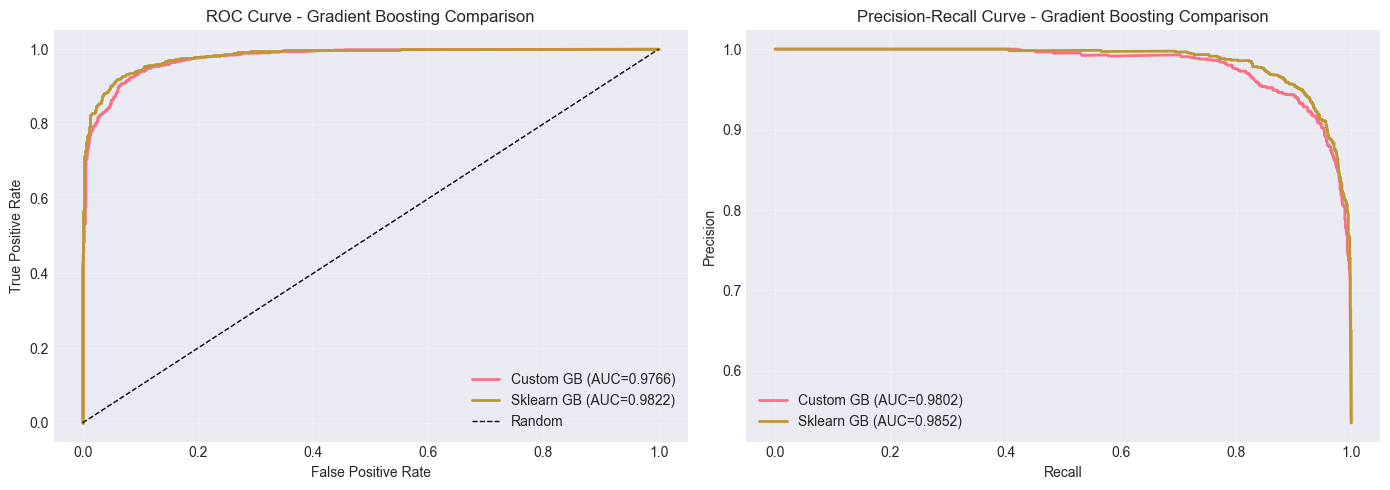

In [114]:
def compare_gradient_boosting(X_train, X_val, y_train, y_val):
    """Сравнение реализации Gradient Boosting с sklearn"""

    # Параметры
    n_estimators = 100
    learning_rate = 0.1
    max_depth = 3
    random_state = 42

    # Наша реализация
    print("\nОбучение Custom Gradient Boosting...")
    custom_gb = CustomGradientBoosting(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        random_state=random_state,
    )
    custom_gb.fit(X_train.values, y_train)

    # Sklearn реализация
    print("Обучение Sklearn Gradient Boosting...")
    sklearn_gb = GradientBoostingClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        random_state=random_state,
    )
    sklearn_gb.fit(X_train, y_train)

    # Предсказания
    custom_pred = custom_gb.predict(X_val.values)
    custom_proba = custom_gb.predict_proba(X_val.values)[:, 1]

    sklearn_pred = sklearn_gb.predict(X_val)
    sklearn_proba = sklearn_gb.predict_proba(X_val)[:, 1]

    # Метрики
    print("\n" + "-" * 80)
    print("РЕЗУЛЬТАТЫ CUSTOM GRADIENT BOOSTING:")
    print("-" * 80)
    print(f"Accuracy:  {CustomAccuracy.calculate(y_val, custom_pred):.6f}")
    print(f"Precision: {CustomPrecision.calculate(y_val, custom_pred):.6f}")
    print(f"Recall:    {CustomRecall.calculate(y_val, custom_pred):.6f}")
    print(f"F1-Score:  {CustomF1Score.calculate(y_val, custom_pred):.6f}")
    print(f"ROC-AUC:   {CustomROCAUC.calculate(y_val, custom_proba):.6f}")
    print(f"PR-AUC:    {CustomPRAUC.calculate(y_val, custom_proba):.6f}")

    print("\n" + "-" * 80)
    print("РЕЗУЛЬТАТЫ SKLEARN GRADIENT BOOSTING:")
    print("-" * 80)
    print(f"Accuracy:  {CustomAccuracy.calculate(y_val, sklearn_pred):.6f}")
    print(f"Precision: {CustomPrecision.calculate(y_val, sklearn_pred):.6f}")
    print(f"Recall:    {CustomRecall.calculate(y_val, sklearn_pred):.6f}")
    print(f"F1-Score:  {CustomF1Score.calculate(y_val, sklearn_pred):.6f}")
    print(f"ROC-AUC:   {CustomROCAUC.calculate(y_val, sklearn_proba):.6f}")
    print(f"PR-AUC:    {CustomPRAUC.calculate(y_val, sklearn_proba):.6f}")

    # Визуализация
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # ROC кривая
    fpr_custom, tpr_custom, _ = roc_curve(y_val, custom_proba)
    fpr_sklearn, tpr_sklearn, _ = roc_curve(y_val, sklearn_proba)

    axes[0].plot(
        fpr_custom,
        tpr_custom,
        label=f"Custom GB (AUC={CustomROCAUC.calculate(y_val, custom_proba):.4f})",
        linewidth=2,
    )
    axes[0].plot(
        fpr_sklearn,
        tpr_sklearn,
        label=f"Sklearn GB (AUC={CustomROCAUC.calculate(y_val, sklearn_proba):.4f})",
        linewidth=2,
    )
    axes[0].plot([0, 1], [0, 1], "k--", label="Random", linewidth=1)
    axes[0].set_xlabel("False Positive Rate")
    axes[0].set_ylabel("True Positive Rate")
    axes[0].set_title("ROC Curve - Gradient Boosting Comparison")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # PR кривая
    precision_custom, recall_custom, _ = precision_recall_curve(y_val, custom_proba)
    precision_sklearn, recall_sklearn, _ = precision_recall_curve(y_val, sklearn_proba)

    axes[1].plot(
        recall_custom,
        precision_custom,
        label=f"Custom GB (AUC={CustomPRAUC.calculate(y_val, custom_proba):.4f})",
        linewidth=2,
    )
    axes[1].plot(
        recall_sklearn,
        precision_sklearn,
        label=f"Sklearn GB (AUC={CustomPRAUC.calculate(y_val, sklearn_proba):.4f})",
        linewidth=2,
    )
    axes[1].set_xlabel("Recall")
    axes[1].set_ylabel("Precision")
    axes[1].set_title("Precision-Recall Curve - Gradient Boosting Comparison")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return custom_gb, sklearn_gb


custom_gb, sklearn_gb = compare_gradient_boosting(X_tr, X_val, y_tr, y_val)

# Сравнение различных библиотек градиентного бустинга


Обучение Sklearn GradientBoosting...
Обучение LightGBM...
Обучение XGBoost...
Обучение CatBoost...

--------------------------------------------------------------------------------
СРАВНЕНИЕ РЕЗУЛЬТАТОВ:
--------------------------------------------------------------------------------
Модель               ROC-AUC      PR-AUC      
--------------------------------------------------------------------------------
Sklearn GB           0.982850     0.986006    
LightGBM             0.983587     0.986728    
XGBoost              0.983657     0.986704    
CatBoost             0.984401     0.987303    

ЛУЧШАЯ МОДЕЛЬ: CatBoost
ROC-AUC: 0.984401


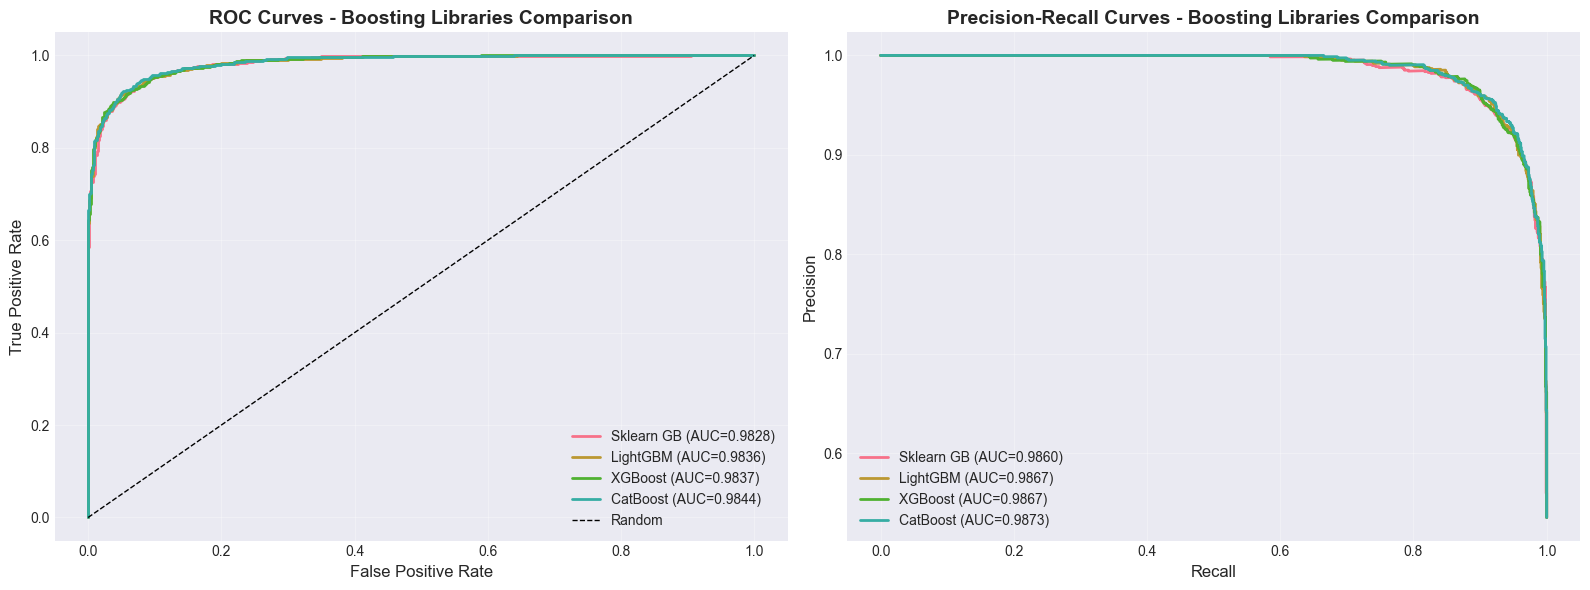

In [116]:
def compare_boosting_libraries(X_train, X_val, y_train, y_val):
    """Сравнение различных библиотек градиентного бустинга"""

    results = {}

    # Sklearn Gradient Boosting
    print("\nОбучение Sklearn GradientBoosting...")
    sklearn_gb = GradientBoostingClassifier(
        n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42
    )
    sklearn_gb.fit(X_train, y_train)
    sklearn_proba = sklearn_gb.predict_proba(X_val)[:, 1]
    results["Sklearn GB"] = {
        "model": sklearn_gb,
        "proba": sklearn_proba,
        "roc_auc": CustomROCAUC.calculate(y_val, sklearn_proba),
        "pr_auc": CustomPRAUC.calculate(y_val, sklearn_proba),
    }

    # LightGBM
    print("Обучение LightGBM...")
    lgb_model = lgb.LGBMClassifier(
        n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42, verbose=-1
    )
    lgb_model.fit(X_train, y_train)
    lgb_proba = lgb_model.predict_proba(X_val)[:, 1]
    results["LightGBM"] = {
        "model": lgb_model,
        "proba": lgb_proba,
        "roc_auc": CustomROCAUC.calculate(y_val, lgb_proba),
        "pr_auc": CustomPRAUC.calculate(y_val, lgb_proba),
    }

    # XGBoost
    print("Обучение XGBoost...")
    xgb_model = xgb.XGBClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        random_state=42,
        eval_metric="logloss",
    )
    xgb_model.fit(X_train, y_train)
    xgb_proba = xgb_model.predict_proba(X_val)[:, 1]
    results["XGBoost"] = {
        "model": xgb_model,
        "proba": xgb_proba,
        "roc_auc": CustomROCAUC.calculate(y_val, xgb_proba),
        "pr_auc": CustomPRAUC.calculate(y_val, xgb_proba),
    }

    # CatBoost
    print("Обучение CatBoost...")
    catboost_model = CatBoostClassifier(
        iterations=200, learning_rate=0.1, depth=5, random_state=42, verbose=False
    )
    catboost_model.fit(X_train, y_train)
    catboost_proba = catboost_model.predict_proba(X_val)[:, 1]
    results["CatBoost"] = {
        "model": catboost_model,
        "proba": catboost_proba,
        "roc_auc": CustomROCAUC.calculate(y_val, catboost_proba),
        "pr_auc": CustomPRAUC.calculate(y_val, catboost_proba),
    }

    # Вывод результатов
    print("\n" + "-" * 80)
    print("СРАВНЕНИЕ РЕЗУЛЬТАТОВ:")
    print("-" * 80)
    print(f"{'Модель':<20} {'ROC-AUC':<12} {'PR-AUC':<12}")
    print("-" * 80)
    for name, res in results.items():
        print(f"{name:<20} {res['roc_auc']:<12.6f} {res['pr_auc']:<12.6f}")

    # Находим лучшую модель
    best_model_name = max(results, key=lambda x: results[x]["roc_auc"])
    print("\n" + "=" * 80)
    print(f"ЛУЧШАЯ МОДЕЛЬ: {best_model_name}")
    print(f"ROC-AUC: {results[best_model_name]['roc_auc']:.6f}")
    print("=" * 80)

    # Визуализация сравнения
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # ROC кривые
    for name, res in results.items():
        fpr, tpr, _ = roc_curve(y_val, res["proba"])
        axes[0].plot(fpr, tpr, label=f"{name} (AUC={res['roc_auc']:.4f})", linewidth=2)
    axes[0].plot([0, 1], [0, 1], "k--", label="Random", linewidth=1)
    axes[0].set_xlabel("False Positive Rate", fontsize=12)
    axes[0].set_ylabel("True Positive Rate", fontsize=12)
    axes[0].set_title(
        "ROC Curves - Boosting Libraries Comparison", fontsize=14, fontweight="bold"
    )
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)

    # PR кривые
    for name, res in results.items():
        precision, recall, _ = precision_recall_curve(y_val, res["proba"])
        axes[1].plot(
            recall, precision, label=f"{name} (AUC={res['pr_auc']:.4f})", linewidth=2
        )
    axes[1].set_xlabel("Recall", fontsize=12)
    axes[1].set_ylabel("Precision", fontsize=12)
    axes[1].set_title(
        "Precision-Recall Curves - Boosting Libraries Comparison",
        fontsize=14,
        fontweight="bold",
    )
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return results, best_model_name


results, best_model_name = compare_boosting_libraries(X_tr, X_val, y_tr, y_val)

# Оптимизация гиперпараметров с помощью Optuna

[I 2025-12-14 22:32:33,198] A new study created in memory with name: CatBoost_optimization



Запуск оптимизации (50 итераций)...


Best trial: 0. Best value: 0.984008:   2%|▏         | 1/50 [00:03<03:02,  3.72s/it]

[I 2025-12-14 22:32:36,920] Trial 0 finished with value: 0.9840083752648304 and parameters: {'iterations': 415, 'learning_rate': 0.19937025938303501, 'depth': 10, 'l2_leaf_reg': 7.42619043744347, 'border_count': 157}. Best is trial 0 with value: 0.9840083752648304.


Best trial: 1. Best value: 0.98443:   4%|▍         | 2/50 [00:07<02:49,  3.53s/it] 

[I 2025-12-14 22:32:40,311] Trial 1 finished with value: 0.9844304488877119 and parameters: {'iterations': 431, 'learning_rate': 0.044934089050775956, 'depth': 10, 'l2_leaf_reg': 3.7958196347775104, 'border_count': 140}. Best is trial 1 with value: 0.9844304488877119.


Best trial: 1. Best value: 0.98443:   6%|▌         | 3/50 [00:07<01:34,  2.02s/it]

[I 2025-12-14 22:32:40,532] Trial 2 finished with value: 0.9820362155720338 and parameters: {'iterations': 129, 'learning_rate': 0.05382670159805637, 'depth': 4, 'l2_leaf_reg': 9.534051212294186, 'border_count': 39}. Best is trial 1 with value: 0.9844304488877119.


Best trial: 1. Best value: 0.98443:   8%|▊         | 4/50 [00:07<01:05,  1.42s/it]

[I 2025-12-14 22:32:41,031] Trial 3 finished with value: 0.9833024364406779 and parameters: {'iterations': 139, 'learning_rate': 0.2574105776857935, 'depth': 9, 'l2_leaf_reg': 1.6069171721770554, 'border_count': 103}. Best is trial 1 with value: 0.9844304488877119.


Best trial: 1. Best value: 0.98443:  10%|█         | 5/50 [00:08<00:52,  1.16s/it]

[I 2025-12-14 22:32:41,739] Trial 4 finished with value: 0.9828216035487288 and parameters: {'iterations': 489, 'learning_rate': 0.04187621521691702, 'depth': 3, 'l2_leaf_reg': 5.163268763991118, 'border_count': 156}. Best is trial 1 with value: 0.9844304488877119.


Best trial: 1. Best value: 0.98443:  12%|█▏        | 6/50 [00:09<00:43,  1.00it/s]

[I 2025-12-14 22:32:42,417] Trial 5 finished with value: 0.9843154131355932 and parameters: {'iterations': 406, 'learning_rate': 0.1793573403546635, 'depth': 5, 'l2_leaf_reg': 7.258469040768495, 'border_count': 63}. Best is trial 1 with value: 0.9844304488877119.


Best trial: 1. Best value: 0.98443:  14%|█▍        | 7/50 [00:10<00:50,  1.16s/it]

[I 2025-12-14 22:32:43,921] Trial 6 finished with value: 0.9830442266949153 and parameters: {'iterations': 435, 'learning_rate': 0.2888979414020383, 'depth': 8, 'l2_leaf_reg': 1.6154496362429835, 'border_count': 236}. Best is trial 1 with value: 0.9844304488877119.


Best trial: 1. Best value: 0.98443:  16%|█▌        | 8/50 [00:11<00:42,  1.02s/it]

[I 2025-12-14 22:32:44,620] Trial 7 finished with value: 0.9838817531779661 and parameters: {'iterations': 426, 'learning_rate': 0.2867837861644642, 'depth': 5, 'l2_leaf_reg': 6.999501858326678, 'border_count': 55}. Best is trial 1 with value: 0.9844304488877119.


Best trial: 1. Best value: 0.98443:  18%|█▊        | 9/50 [00:12<00:36,  1.12it/s]

[I 2025-12-14 22:32:45,238] Trial 8 finished with value: 0.9840414790783898 and parameters: {'iterations': 325, 'learning_rate': 0.19809248704451138, 'depth': 6, 'l2_leaf_reg': 3.355637678305544, 'border_count': 34}. Best is trial 1 with value: 0.9844304488877119.


Best trial: 1. Best value: 0.98443:  20%|██        | 10/50 [00:12<00:30,  1.31it/s]

[I 2025-12-14 22:32:45,717] Trial 9 finished with value: 0.9838511321504237 and parameters: {'iterations': 311, 'learning_rate': 0.16152143936715785, 'depth': 4, 'l2_leaf_reg': 5.351837851727922, 'border_count': 48}. Best is trial 1 with value: 0.9844304488877119.


Best trial: 1. Best value: 0.98443:  22%|██▏       | 11/50 [00:13<00:29,  1.34it/s]

[I 2025-12-14 22:32:46,417] Trial 10 finished with value: 0.983352919756356 and parameters: {'iterations': 212, 'learning_rate': 0.09305528876061159, 'depth': 8, 'l2_leaf_reg': 3.5881984279874417, 'border_count': 205}. Best is trial 1 with value: 0.9844304488877119.


Best trial: 1. Best value: 0.98443:  24%|██▍       | 12/50 [00:14<00:29,  1.30it/s]

[I 2025-12-14 22:32:47,241] Trial 11 finished with value: 0.9840836864406779 and parameters: {'iterations': 359, 'learning_rate': 0.11126427954772072, 'depth': 7, 'l2_leaf_reg': 7.050937092948363, 'border_count': 105}. Best is trial 1 with value: 0.9844304488877119.


Best trial: 1. Best value: 0.98443:  26%|██▌       | 13/50 [00:15<00:30,  1.20it/s]

[I 2025-12-14 22:32:48,221] Trial 12 finished with value: 0.9826444981461864 and parameters: {'iterations': 495, 'learning_rate': 0.01297928769401513, 'depth': 6, 'l2_leaf_reg': 8.862905747817884, 'border_count': 111}. Best is trial 1 with value: 0.9844304488877119.


Best trial: 1. Best value: 0.98443:  28%|██▊       | 14/50 [00:17<00:50,  1.39s/it]

[I 2025-12-14 22:32:50,907] Trial 13 finished with value: 0.9843311374470338 and parameters: {'iterations': 240, 'learning_rate': 0.13089744595686062, 'depth': 10, 'l2_leaf_reg': 3.8483614105397685, 'border_count': 191}. Best is trial 1 with value: 0.9844304488877119.


Best trial: 14. Best value: 0.984656:  30%|███       | 15/50 [00:20<01:01,  1.77s/it]

[I 2025-12-14 22:32:53,542] Trial 14 finished with value: 0.9846555548199152 and parameters: {'iterations': 250, 'learning_rate': 0.11560508076171516, 'depth': 10, 'l2_leaf_reg': 3.7264973773391805, 'border_count': 192}. Best is trial 14 with value: 0.9846555548199152.


Best trial: 14. Best value: 0.984656:  32%|███▏      | 16/50 [00:21<00:53,  1.59s/it]

[I 2025-12-14 22:32:54,708] Trial 15 finished with value: 0.9842028601694915 and parameters: {'iterations': 231, 'learning_rate': 0.07648270547064281, 'depth': 9, 'l2_leaf_reg': 2.7048804600889698, 'border_count': 196}. Best is trial 14 with value: 0.9846555548199152.


Best trial: 14. Best value: 0.984656:  34%|███▍      | 17/50 [00:23<00:59,  1.79s/it]

[I 2025-12-14 22:32:56,968] Trial 16 finished with value: 0.9823631157309322 and parameters: {'iterations': 273, 'learning_rate': 0.013706144914019863, 'depth': 10, 'l2_leaf_reg': 4.7163199836632215, 'border_count': 132}. Best is trial 14 with value: 0.9846555548199152.


Best trial: 14. Best value: 0.984656:  36%|███▌      | 18/50 [00:24<00:50,  1.57s/it]

[I 2025-12-14 22:32:58,029] Trial 17 finished with value: 0.983976926641949 and parameters: {'iterations': 187, 'learning_rate': 0.13265984858435403, 'depth': 9, 'l2_leaf_reg': 2.6731081347029884, 'border_count': 252}. Best is trial 14 with value: 0.9846555548199152.


Best trial: 18. Best value: 0.984894:  38%|███▊      | 19/50 [00:25<00:44,  1.44s/it]

[I 2025-12-14 22:32:59,156] Trial 18 finished with value: 0.9848939022775423 and parameters: {'iterations': 362, 'learning_rate': 0.06349801602050177, 'depth': 8, 'l2_leaf_reg': 4.289999972702291, 'border_count': 176}. Best is trial 18 with value: 0.9848939022775423.


Best trial: 18. Best value: 0.984894:  40%|████      | 20/50 [00:27<00:40,  1.34s/it]

[I 2025-12-14 22:33:00,286] Trial 19 finished with value: 0.9842177568855932 and parameters: {'iterations': 368, 'learning_rate': 0.07702520635969631, 'depth': 8, 'l2_leaf_reg': 6.347888564303233, 'border_count': 175}. Best is trial 18 with value: 0.9848939022775423.


Best trial: 18. Best value: 0.984894:  42%|████▏     | 21/50 [00:27<00:33,  1.16s/it]

[I 2025-12-14 22:33:01,006] Trial 20 finished with value: 0.9838014764300848 and parameters: {'iterations': 280, 'learning_rate': 0.23578970669617766, 'depth': 7, 'l2_leaf_reg': 1.0441761869074577, 'border_count': 220}. Best is trial 18 with value: 0.9848939022775423.


Best trial: 18. Best value: 0.984894:  44%|████▍     | 22/50 [00:29<00:34,  1.23s/it]

[I 2025-12-14 22:33:02,400] Trial 21 finished with value: 0.9843427237817797 and parameters: {'iterations': 356, 'learning_rate': 0.048283010016853034, 'depth': 9, 'l2_leaf_reg': 4.437651608634386, 'border_count': 136}. Best is trial 18 with value: 0.9848939022775423.


Best trial: 18. Best value: 0.984894:  46%|████▌     | 23/50 [00:33<01:01,  2.30s/it]

[I 2025-12-14 22:33:07,183] Trial 22 finished with value: 0.9838494769597458 and parameters: {'iterations': 466, 'learning_rate': 0.10637624256027747, 'depth': 10, 'l2_leaf_reg': 5.968818408764699, 'border_count': 176}. Best is trial 18 with value: 0.9848939022775423.


Best trial: 23. Best value: 0.985029:  48%|████▊     | 24/50 [00:35<00:51,  2.00s/it]

[I 2025-12-14 22:33:08,486] Trial 23 finished with value: 0.9850288003177965 and parameters: {'iterations': 383, 'learning_rate': 0.06750080767566204, 'depth': 8, 'l2_leaf_reg': 2.746163082654094, 'border_count': 168}. Best is trial 23 with value: 0.9850288003177965.


Best trial: 23. Best value: 0.985029:  50%|█████     | 25/50 [00:36<00:44,  1.78s/it]

[I 2025-12-14 22:33:09,746] Trial 24 finished with value: 0.9839603747351695 and parameters: {'iterations': 388, 'learning_rate': 0.1348106905201138, 'depth': 8, 'l2_leaf_reg': 2.678995409603554, 'border_count': 176}. Best is trial 23 with value: 0.9850288003177965.


Best trial: 23. Best value: 0.985029:  52%|█████▏    | 26/50 [00:37<00:36,  1.51s/it]

[I 2025-12-14 22:33:10,635] Trial 25 finished with value: 0.9842161016949151 and parameters: {'iterations': 332, 'learning_rate': 0.08227296832053428, 'depth': 7, 'l2_leaf_reg': 2.012228596322306, 'border_count': 217}. Best is trial 23 with value: 0.9850288003177965.


Best trial: 23. Best value: 0.985029:  54%|█████▍    | 27/50 [00:38<00:33,  1.45s/it]

[I 2025-12-14 22:33:11,933] Trial 26 finished with value: 0.9835581634004237 and parameters: {'iterations': 280, 'learning_rate': 0.10712427851327942, 'depth': 9, 'l2_leaf_reg': 4.419867807515162, 'border_count': 161}. Best is trial 23 with value: 0.9850288003177965.


Best trial: 23. Best value: 0.985029:  56%|█████▌    | 28/50 [00:39<00:28,  1.30s/it]

[I 2025-12-14 22:33:12,896] Trial 27 finished with value: 0.9849352820444915 and parameters: {'iterations': 339, 'learning_rate': 0.06833956188571377, 'depth': 8, 'l2_leaf_reg': 3.238820217470846, 'border_count': 123}. Best is trial 23 with value: 0.9850288003177965.


Best trial: 23. Best value: 0.985029:  58%|█████▊    | 29/50 [00:40<00:24,  1.16s/it]

[I 2025-12-14 22:33:13,739] Trial 28 finished with value: 0.9844081038135593 and parameters: {'iterations': 380, 'learning_rate': 0.06067799983413906, 'depth': 7, 'l2_leaf_reg': 3.019079222628739, 'border_count': 80}. Best is trial 23 with value: 0.9850288003177965.


Best trial: 23. Best value: 0.985029:  60%|██████    | 30/50 [00:41<00:22,  1.10s/it]

[I 2025-12-14 22:33:14,703] Trial 29 finished with value: 0.983736923993644 and parameters: {'iterations': 338, 'learning_rate': 0.023163228712710746, 'depth': 8, 'l2_leaf_reg': 2.0332999966613956, 'border_count': 123}. Best is trial 23 with value: 0.9850288003177965.


Best trial: 23. Best value: 0.985029:  62%|██████▏   | 31/50 [00:42<00:19,  1.02s/it]

[I 2025-12-14 22:33:15,522] Trial 30 finished with value: 0.9838800979872881 and parameters: {'iterations': 400, 'learning_rate': 0.154710229974652, 'depth': 6, 'l2_leaf_reg': 4.857392737184904, 'border_count': 153}. Best is trial 23 with value: 0.9850288003177965.


Best trial: 23. Best value: 0.985029:  64%|██████▍   | 32/50 [00:43<00:17,  1.00it/s]

[I 2025-12-14 22:33:16,473] Trial 31 finished with value: 0.9847292108050847 and parameters: {'iterations': 299, 'learning_rate': 0.06665828654216115, 'depth': 8, 'l2_leaf_reg': 4.066020623069071, 'border_count': 168}. Best is trial 23 with value: 0.9850288003177965.


Best trial: 23. Best value: 0.985029:  66%|██████▌   | 33/50 [00:44<00:16,  1.02it/s]

[I 2025-12-14 22:33:17,419] Trial 32 finished with value: 0.9840845140360168 and parameters: {'iterations': 302, 'learning_rate': 0.0339404730136109, 'depth': 8, 'l2_leaf_reg': 4.206412219003302, 'border_count': 164}. Best is trial 23 with value: 0.9850288003177965.


Best trial: 23. Best value: 0.985029:  68%|██████▊   | 34/50 [00:45<00:15,  1.06it/s]

[I 2025-12-14 22:33:18,262] Trial 33 finished with value: 0.9841639631885593 and parameters: {'iterations': 347, 'learning_rate': 0.0644930383709409, 'depth': 7, 'l2_leaf_reg': 5.808492673847219, 'border_count': 145}. Best is trial 23 with value: 0.9850288003177965.


Best trial: 23. Best value: 0.985029:  70%|███████   | 35/50 [00:46<00:17,  1.18s/it]

[I 2025-12-14 22:33:20,009] Trial 34 finished with value: 0.9843700344279661 and parameters: {'iterations': 452, 'learning_rate': 0.09430511559123249, 'depth': 9, 'l2_leaf_reg': 3.1023185295385565, 'border_count': 122}. Best is trial 23 with value: 0.9850288003177965.


Best trial: 23. Best value: 0.985029:  72%|███████▏  | 36/50 [00:47<00:15,  1.08s/it]

[I 2025-12-14 22:33:20,866] Trial 35 finished with value: 0.9836326469809322 and parameters: {'iterations': 316, 'learning_rate': 0.03683152233255922, 'depth': 8, 'l2_leaf_reg': 4.020738149806445, 'border_count': 79}. Best is trial 23 with value: 0.9850288003177965.


Best trial: 23. Best value: 0.985029:  74%|███████▍  | 37/50 [00:49<00:16,  1.25s/it]

[I 2025-12-14 22:33:22,506] Trial 36 finished with value: 0.9842549986758473 and parameters: {'iterations': 374, 'learning_rate': 0.060736187769463434, 'depth': 9, 'l2_leaf_reg': 2.288797892506547, 'border_count': 146}. Best is trial 23 with value: 0.9850288003177965.


Best trial: 23. Best value: 0.985029:  76%|███████▌  | 38/50 [00:50<00:14,  1.20s/it]

[I 2025-12-14 22:33:23,583] Trial 37 finished with value: 0.9841995497881356 and parameters: {'iterations': 415, 'learning_rate': 0.0884144438993077, 'depth': 7, 'l2_leaf_reg': 8.412884756427157, 'border_count': 170}. Best is trial 23 with value: 0.9850288003177965.


Best trial: 23. Best value: 0.985029:  78%|███████▊  | 39/50 [00:51<00:11,  1.06s/it]

[I 2025-12-14 22:33:24,326] Trial 38 finished with value: 0.9844196901483051 and parameters: {'iterations': 280, 'learning_rate': 0.06725411333535722, 'depth': 8, 'l2_leaf_reg': 1.3416236584850134, 'border_count': 86}. Best is trial 23 with value: 0.9850288003177965.


Best trial: 23. Best value: 0.985029:  80%|████████  | 40/50 [00:51<00:09,  1.01it/s]

[I 2025-12-14 22:33:25,157] Trial 39 finished with value: 0.9841697563559322 and parameters: {'iterations': 392, 'learning_rate': 0.04655265601934197, 'depth': 6, 'l2_leaf_reg': 4.929093987443961, 'border_count': 184}. Best is trial 23 with value: 0.9850288003177965.


Best trial: 23. Best value: 0.985029:  82%|████████▏ | 41/50 [00:52<00:08,  1.05it/s]

[I 2025-12-14 22:33:26,011] Trial 40 finished with value: 0.9832287804555084 and parameters: {'iterations': 448, 'learning_rate': 0.024395329144438427, 'depth': 5, 'l2_leaf_reg': 3.274926598986533, 'border_count': 212}. Best is trial 23 with value: 0.9850288003177965.


Best trial: 23. Best value: 0.985029:  84%|████████▍ | 42/50 [00:55<00:10,  1.33s/it]

[I 2025-12-14 22:33:28,209] Trial 41 finished with value: 0.9842409295550847 and parameters: {'iterations': 163, 'learning_rate': 0.12378237622943672, 'depth': 10, 'l2_leaf_reg': 3.70943700470991, 'border_count': 198}. Best is trial 23 with value: 0.9850288003177965.


Best trial: 23. Best value: 0.985029:  86%|████████▌ | 43/50 [00:55<00:07,  1.08s/it]

[I 2025-12-14 22:33:28,731] Trial 42 finished with value: 0.9822108381885593 and parameters: {'iterations': 104, 'learning_rate': 0.15131161693116468, 'depth': 9, 'l2_leaf_reg': 3.5898389217596454, 'border_count': 185}. Best is trial 23 with value: 0.9850288003177965.


Best trial: 23. Best value: 0.985029:  88%|████████▊ | 44/50 [00:56<00:06,  1.04s/it]

[I 2025-12-14 22:33:29,678] Trial 43 finished with value: 0.9841176178495762 and parameters: {'iterations': 254, 'learning_rate': 0.11200376340202911, 'depth': 8, 'l2_leaf_reg': 2.3486687781522866, 'border_count': 229}. Best is trial 23 with value: 0.9850288003177965.


Best trial: 23. Best value: 0.985029:  90%|█████████ | 45/50 [00:57<00:05,  1.11s/it]

[I 2025-12-14 22:33:30,957] Trial 44 finished with value: 0.9839347192796609 and parameters: {'iterations': 299, 'learning_rate': 0.07451115148970935, 'depth': 9, 'l2_leaf_reg': 5.205461458054559, 'border_count': 153}. Best is trial 23 with value: 0.9850288003177965.


Best trial: 23. Best value: 0.985029:  92%|█████████▏| 46/50 [00:59<00:05,  1.41s/it]

[I 2025-12-14 22:33:33,044] Trial 45 finished with value: 0.9844453456038136 and parameters: {'iterations': 210, 'learning_rate': 0.09704856256909816, 'depth': 10, 'l2_leaf_reg': 4.165198386879107, 'border_count': 163}. Best is trial 23 with value: 0.9850288003177965.


Best trial: 23. Best value: 0.985029:  94%|█████████▍| 47/50 [01:00<00:03,  1.11s/it]

[I 2025-12-14 22:33:33,448] Trial 46 finished with value: 0.9827744306144067 and parameters: {'iterations': 262, 'learning_rate': 0.17780887633291104, 'depth': 3, 'l2_leaf_reg': 3.0725968136791524, 'border_count': 205}. Best is trial 23 with value: 0.9850288003177965.


Best trial: 23. Best value: 0.985029:  96%|█████████▌| 48/50 [01:01<00:01,  1.00it/s]

[I 2025-12-14 22:33:34,201] Trial 47 finished with value: 0.9841035487288137 and parameters: {'iterations': 295, 'learning_rate': 0.05813844254538196, 'depth': 7, 'l2_leaf_reg': 3.53248197978168, 'border_count': 185}. Best is trial 23 with value: 0.9850288003177965.


Best trial: 23. Best value: 0.985029:  98%|█████████▊| 49/50 [01:01<00:00,  1.03it/s]

[I 2025-12-14 22:33:35,117] Trial 48 finished with value: 0.9842442399364406 and parameters: {'iterations': 322, 'learning_rate': 0.05035071141504904, 'depth': 8, 'l2_leaf_reg': 1.7592582765286506, 'border_count': 127}. Best is trial 23 with value: 0.9850288003177965.


Best trial: 23. Best value: 0.985029: 100%|██████████| 50/50 [01:02<00:00,  1.25s/it]


[I 2025-12-14 22:33:35,552] Trial 49 finished with value: 0.9839769266419491 and parameters: {'iterations': 236, 'learning_rate': 0.12150500516140691, 'depth': 5, 'l2_leaf_reg': 4.665486593788549, 'border_count': 115}. Best is trial 23 with value: 0.9850288003177965.

--------------------------------------------------------------------------------
РЕЗУЛЬТАТЫ ОПТИМИЗАЦИИ:
--------------------------------------------------------------------------------
Лучший ROC-AUC: 0.985029

Лучшие параметры:
  iterations: 383
  learning_rate: 0.06750080767566204
  depth: 8
  l2_leaf_reg: 2.746163082654094
  border_count: 168

Обучение финальной модели с оптимальными параметрами...


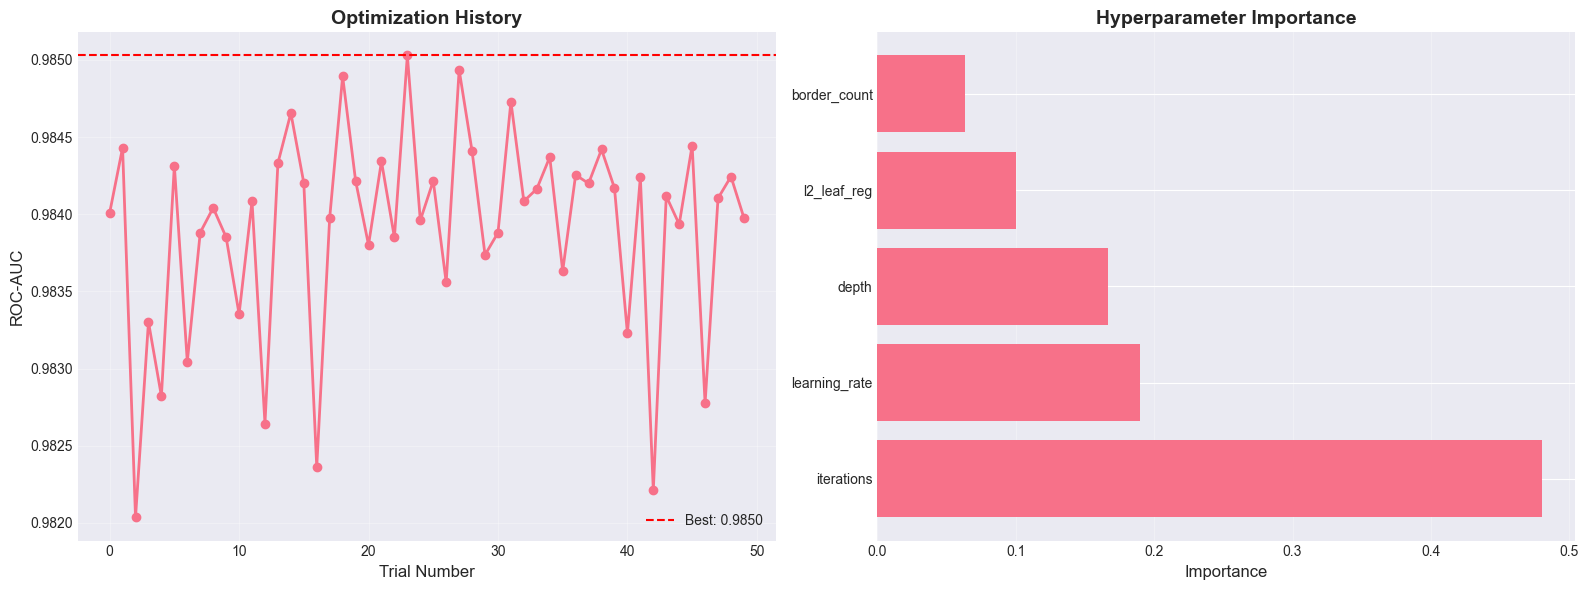

In [119]:
def optimize_hyperparameters(X_train, X_val, y_train, y_val, model_name):
    """Оптимизация гиперпараметров с помощью Optuna"""

    def objective(trial):
        """Целевая функция для оптимизации"""

        if model_name == "LightGBM":
            params = {
                "n_estimators": trial.suggest_int("n_estimators", 100, 500),
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
                "max_depth": trial.suggest_int("max_depth", 3, 10),
                "num_leaves": trial.suggest_int("num_leaves", 20, 100),
                "min_child_samples": trial.suggest_int("min_child_samples", 10, 50),
                "subsample": trial.suggest_float("subsample", 0.6, 1.0),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
                "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
                "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0),
                "random_state": 42,
                "verbose": -1,
            }
            model = lgb.LGBMClassifier(**params)

        elif model_name == "XGBoost":
            params = {
                "n_estimators": trial.suggest_int("n_estimators", 100, 500),
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
                "max_depth": trial.suggest_int("max_depth", 3, 10),
                "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
                "subsample": trial.suggest_float("subsample", 0.6, 1.0),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
                "gamma": trial.suggest_float("gamma", 0.0, 1.0),
                "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
                "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0),
                "random_state": 42,
                "eval_metric": "logloss",
            }
            model = xgb.XGBClassifier(**params)

        elif model_name == "CatBoost":
            params = {
                "iterations": trial.suggest_int("iterations", 100, 500),
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
                "depth": trial.suggest_int("depth", 3, 10),
                "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
                "border_count": trial.suggest_int("border_count", 32, 255),
                "random_state": 42,
                "verbose": False,
            }
            model = CatBoostClassifier(**params)

        else:  # Sklearn GB
            params = {
                "n_estimators": trial.suggest_int("n_estimators", 100, 500),
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
                "max_depth": trial.suggest_int("max_depth", 3, 10),
                "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
                "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
                "subsample": trial.suggest_float("subsample", 0.6, 1.0),
                "random_state": 42,
            }
            model = GradientBoostingClassifier(**params)

        # Обучение и оценка
        model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_val)[:, 1]
        roc_auc = CustomROCAUC.calculate(y_val, y_pred_proba)

        return roc_auc

    # Создание и запуск исследования
    print("\nЗапуск оптимизации (50 итераций)...")
    study = optuna.create_study(
        direction="maximize", study_name=f"{model_name}_optimization"
    )
    study.optimize(objective, n_trials=50, show_progress_bar=True)

    # Результаты
    print("\n" + "-" * 80)
    print("РЕЗУЛЬТАТЫ ОПТИМИЗАЦИИ:")
    print("-" * 80)
    print(f"Лучший ROC-AUC: {study.best_value:.6f}")
    print(f"\nЛучшие параметры:")
    for param, value in study.best_params.items():
        print(f"  {param}: {value}")

    # Обучение финальной модели с лучшими параметрами
    print("\nОбучение финальной модели с оптимальными параметрами...")
    if model_name == "LightGBM":
        best_model = lgb.LGBMClassifier(
            **study.best_params, random_state=42, verbose=-1
        )
    elif model_name == "XGBoost":
        best_model = xgb.XGBClassifier(
            **study.best_params, random_state=42, eval_metric="logloss"
        )
    elif model_name == "CatBoost":
        best_model = CatBoostClassifier(
            **study.best_params, random_state=42, verbose=False
        )
    else:
        best_model = GradientBoostingClassifier(**study.best_params, random_state=42)

    best_model.fit(X_train, y_train)

    # Визуализация истории оптимизации
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # История оптимизации
    trials_df = study.trials_dataframe()
    axes[0].plot(trials_df["number"], trials_df["value"], marker="o", linewidth=2)
    axes[0].axhline(
        y=study.best_value,
        color="r",
        linestyle="--",
        label=f"Best: {study.best_value:.4f}",
    )
    axes[0].set_xlabel("Trial Number", fontsize=12)
    axes[0].set_ylabel("ROC-AUC", fontsize=12)
    axes[0].set_title("Optimization History", fontsize=14, fontweight="bold")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Важность параметров
    param_importance = optuna.importance.get_param_importances(study)
    params = list(param_importance.keys())
    importances = list(param_importance.values())

    axes[1].barh(params, importances)
    axes[1].set_xlabel("Importance", fontsize=12)
    axes[1].set_title("Hyperparameter Importance", fontsize=14, fontweight="bold")
    axes[1].grid(True, alpha=0.3, axis="x")

    plt.tight_layout()
    plt.show()

    return best_model, study.best_params


best_model, best_params = optimize_hyperparameters(
    X_tr, X_val, y_tr, y_val, best_model_name
)

Accuracy: 0.932849
Precision: 0.930000
Recall: 0.945763
F1-Score: 0.937815
AUC-ROC: 0.985029
AUC-PR: 0.987632

--------------------------------------------------------------------------------
CONFUSION MATRIX:
--------------------------------------------------------------------------------
[[ 940   84]
 [  64 1116]]


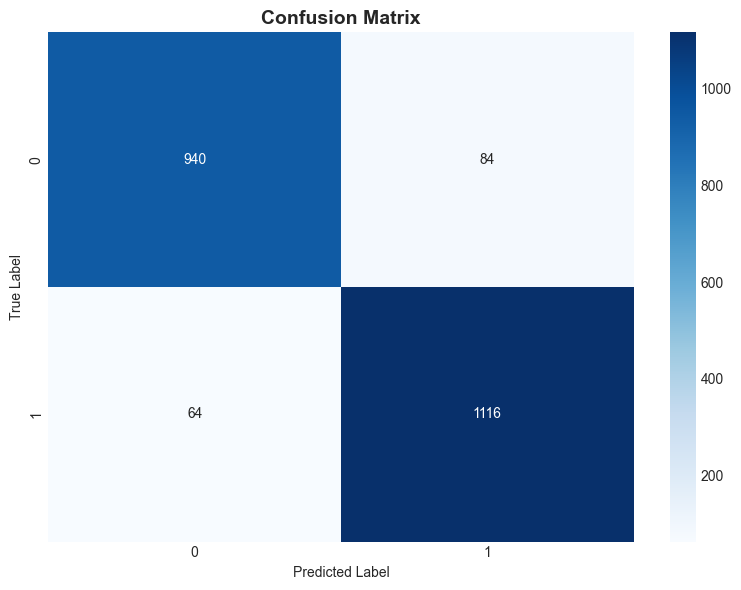


--------------------------------------------------------------------------------
CLASSIFICATION REPORT:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

     Class 0       0.94      0.92      0.93      1024
     Class 1       0.93      0.95      0.94      1180

    accuracy                           0.93      2204
   macro avg       0.93      0.93      0.93      2204
weighted avg       0.93      0.93      0.93      2204



In [120]:
# Предсказания на валидации
y_val_pred = best_model.predict(X_val)
y_val_proba = best_model.predict_proba(X_val)[:, 1]

print(f"Accuracy: {CustomAccuracy.calculate(y_val, y_val_pred):.6f}")
print(f"Precision: {CustomPrecision.calculate(y_val, y_val_pred):.6f}")
print(f"Recall: {CustomRecall.calculate(y_val, y_val_pred):.6f}")
print(f"F1-Score: {CustomF1Score.calculate(y_val, y_val_pred):.6f}")
print(f"AUC-ROC: {CustomROCAUC.calculate(y_val, y_val_proba):.6f}")
print(f"AUC-PR: {CustomPRAUC.calculate(y_val, y_val_proba):.6f}")

# Confusion Matrix
print("\n" + "-"*80)
print("CONFUSION MATRIX:")
print("-"*80)
cm = confusion_matrix(y_val, y_val_pred)
print(cm)

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Classification Report
print("\n" + "-"*80)
print("CLASSIFICATION REPORT:")
print("-"*80)
print(classification_report(y_val, y_val_pred, target_names=['Class 0', 'Class 1']))

In [ ]:
def train_final_model_and_predict(
    X_train_full, y_train_full, X_test, best_model, best_params, test_ids=None
):
    """Обучение финальной модели на всех данных и предсказание"""
    print("\n" + "=" * 80)
    print("ОБУЧЕНИЕ ФИНАЛЬНОЙ МОДЕЛИ И ПРЕДСКАЗАНИЕ")
    print("=" * 80)

    print("\nОбучение на полном обучающем наборе...")
    best_model.fit(X_train_full, y_train_full)

    print("Предсказание на тестовом наборе...")
    test_proba = best_model.predict_proba(X_test)[:, 1]

    # Сохранение предсказаний
    submission = pd.DataFrame({"ID": test_ids, "LoanApproved": test_proba})
    submission.to_csv("submission.csv", index=False)

    print("\nПредсказания сохранены в 'submission.csv'")
    print(f"Размер файла: {len(submission)} строк")
    print(f"\nПервые 10 предсказаний:")
    print(submission.head(10))

    return test_proba


train_final_model_and_predict(
    X_train, y_train, X_test, best_model, best_params, test_ids
)